### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score,confusion_matrix,mean_absolute_error
import tensorflow
import ocifs

mpl.rcParams['figure.figsize']=(20,20)
sns.set_style('darkgrid')

In [2]:
dir(ocifs)

['OCIFileSystem',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'core',
 'errors',
 'json',
 'os',
 'register_implementation',
 'sys',
 'version_file']

In [4]:
data=pd.read_csv("oci://datasets/weather.csv",na_values='NULL')
data.head(5)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,M_PACKET_FORMAT,M_GAME_MAJOR_VERSION,M_GAME_MINOR_VERSION,M_PACKET_VERSION,M_PACKET_ID,M_SESSION_UID,M_SESSION_TIME,M_FRAME_IDENTIFIER,M_PLAYER_CAR_INDEX,M_SECONDARY_PLAYER_CAR_INDEX,...,M_AI_DIFFICULTY,M_PIT_SPEED_LIMIT,M_NETWORK_GAME,M_TOTAL_LAPS,M_STEERING_ASSIST,M_IS_SPECTATING,M_DYNAMIC_RACING_LINE,M_DRSASSIST,M_NUM_MARSHAL_ZONES,Unnamed: 58
0,2021,1,14,1,1,1.300210e+19,2803.836,82458,0,255,...,0,80,0.0,200.0,0.0,0.0,0.0,0.0,16.0,NaN
1,2021,1,14,1,1,1.300210e+19,2803.836,82458,0,255,...,0,80,0.0,200.0,0.0,0.0,0.0,0.0,16.0,NaN
2,2021,1,14,1,1,1.300210e+19,2803.836,82458,0,255,...,0,80,0.0,200.0,0.0,0.0,0.0,0.0,16.0,NaN
3,2021,1,14,1,1,1.300210e+19,2803.836,82458,0,255,...,0,80,0.0,200.0,0.0,0.0,0.0,0.0,16.0,NaN
4,2021,1,14,1,1,1.300210e+19,2803.836,82458,0,255,...,0,80,0.0,200.0,0.0,0.0,0.0,0.0,16.0,NaN


In [5]:
org_cols=data.columns.values # Assign Original Columns to a variable
data.shape

(3572328, 59)

There are more than 3572328 entries in the dataset

In [6]:
data.columns

Index(['M_PACKET_FORMAT', 'M_GAME_MAJOR_VERSION', 'M_GAME_MINOR_VERSION',
       'M_PACKET_VERSION', 'M_PACKET_ID', 'M_SESSION_UID', 'M_SESSION_TIME',
       'M_FRAME_IDENTIFIER', 'M_PLAYER_CAR_INDEX',
       'M_SECONDARY_PLAYER_CAR_INDEX', 'M_BRAKING_ASSIST',
       'M_SESSION_LINK_IDENTIFIER', 'M_PIT_RELEASE_ASSIST', 'TIMESTAMP',
       'M_ZONE_START', 'M_ZONE_FLAG', 'M_PIT_STOP_WINDOW_IDEAL_LAP',
       'M_TRACK_TEMPERATURE', 'M_TRACK_LENGTH', 'M_GAME_PAUSED',
       'M_FORECAST_ACCURACY', 'GAMEHOST', 'M_AIR_TEMPERATURE',
       'M_NUM_WEATHER_FORECAST_SAMPLES', 'M_SLI_PRO_NATIVE_SUPPORT',
       'M_SAFETY_CAR_STATUS', 'M_TRACK_ID', 'M_ERSASSIST', 'M_FORMULA',
       'M_SEASON_LINK_IDENTIFIER', 'M_PIT_ASSIST', 'M_GEARBOX_ASSIST',
       'M_SESSION_TYPE', 'M_SPECTATOR_CAR_INDEX',
       'M_PIT_STOP_WINDOW_LATEST_LAP', 'M_WEEKEND_LINK_IDENTIFIER',
       'M_DYNAMIC_RACING_LINE_TYPE', 'M_SESSION_TIME_LEFT',
       'M_SESSION_DURATION', 'M_PIT_STOP_REJOIN_POSITION',
       'M_WEATHER_FO

In [7]:
# Checking for percentage of unique values in each Features
def Unique_percentage(data):
    for col in data.columns:
        temp=data[col].value_counts().shape[0]
        print('Perecntage of unique entries of {} in the data is {:.5f}'.format(col,(temp/len(data)*100)))
Unique_percentage(data)       

Perecntage of unique entries of M_PACKET_FORMAT in the data is 0.00003
Perecntage of unique entries of M_GAME_MAJOR_VERSION in the data is 0.00003
Perecntage of unique entries of M_GAME_MINOR_VERSION in the data is 0.00006
Perecntage of unique entries of M_PACKET_VERSION in the data is 0.00003
Perecntage of unique entries of M_PACKET_ID in the data is 0.00003
Perecntage of unique entries of M_SESSION_UID in the data is 0.00428
Perecntage of unique entries of M_SESSION_TIME in the data is 1.24569
Perecntage of unique entries of M_FRAME_IDENTIFIER in the data is 0.80068
Perecntage of unique entries of M_PLAYER_CAR_INDEX in the data is 0.00022
Perecntage of unique entries of M_SECONDARY_PLAYER_CAR_INDEX in the data is 0.00003
Perecntage of unique entries of M_BRAKING_ASSIST in the data is 0.00008
Perecntage of unique entries of M_SESSION_LINK_IDENTIFIER in the data is 0.00140
Perecntage of unique entries of M_PIT_RELEASE_ASSIST in the data is 0.00006
Perecntage of unique entries of TIMEST

In [8]:
# function to select columns with less varying(Unique) entry
def Vary_features(data,no_of_entries,greater=False):
    cols=[]
    for col in data.columns:
        temp=data[col].value_counts().shape[0]
        if greater:
            if temp>=no_of_entries:
                cols.append(col)
        else:
            if temp<=no_of_entries:
                cols.append(col)
    return cols

In [9]:
Vary_features(data,2) # Features with less than 2 unique entries

['M_PACKET_FORMAT',
 'M_GAME_MAJOR_VERSION',
 'M_GAME_MINOR_VERSION',
 'M_PACKET_VERSION',
 'M_PACKET_ID',
 'M_SECONDARY_PLAYER_CAR_INDEX',
 'M_PIT_RELEASE_ASSIST',
 'M_GAME_PAUSED',
 'M_FORECAST_ACCURACY',
 'GAMEHOST',
 'M_SLI_PRO_NATIVE_SUPPORT',
 'M_SAFETY_CAR_STATUS',
 'M_ERSASSIST',
 'M_FORMULA',
 'M_PIT_ASSIST',
 'M_GEARBOX_ASSIST',
 'M_DYNAMIC_RACING_LINE_TYPE',
 'M_PIT_SPEED_LIMIT',
 'M_NETWORK_GAME',
 'M_STEERING_ASSIST',
 'M_IS_SPECTATING',
 'M_DYNAMIC_RACING_LINE',
 'M_DRSASSIST',
 'Unnamed: 58']

In [10]:
# Dropping No vary list
data.drop(Vary_features(data,2),axis=1,inplace=True)
data.shape

(3572328, 35)

In [11]:
# Correlation Matrix of Features
corr_mat=data[data.notnull()].corr()
corr_mat

,M_SESSION_UID,M_SESSION_TIME,M_FRAME_IDENTIFIER,M_PLAYER_CAR_INDEX,M_BRAKING_ASSIST,M_SESSION_LINK_IDENTIFIER,TIMESTAMP,M_ZONE_START,M_ZONE_FLAG,M_PIT_STOP_WINDOW_IDEAL_LAP,...,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER,M_AI_DIFFICULTY,M_TOTAL_LAPS,M_NUM_MARSHAL_ZONES
M_SESSION_UID,1.000000,-0.026253,0.081489,-0.309782,-0.577552,-0.289094,0.307128,-0.004335,-0.006250,-0.086083,...,-0.158760,-0.299517,-0.280651,-0.312282,-0.277000,-0.177354,-0.067724,0.027049,0.094819,-0.024162
M_SESSION_TIME,-0.026253,1.000000,0.974000,-0.145722,0.129913,-0.162111,-0.066116,0.003855,-0.024882,-0.085473,...,0.069415,0.077461,0.073772,0.087747,0.066543,0.050886,-0.007734,-0.370052,0.197510,-0.079008
M_FRAME_IDENTIFIER,0.081489,0.974000,1.000000,-0.222771,-0.001850,-0.238041,-0.016331,0.002338,-0.022625,-0.077937,...,0.008158,-0.021968,-0.019666,-0.016391,-0.024572,-0.006011,-0.037441,-0.341430,0.175239,-0.103656
M_PLAYER_CAR_INDEX,-0.309782,-0.145722,-0.222771,1.000000,0.297083,0.412029,-0.225441,-0.011260,-0.036366,-0.099823,...,0.138856,0.385970,0.356281,0.401466,0.355706,0.139027,-0.265795,0.465877,-0.062349,-0.067844
M_BRAKING_ASSIST,-0.577552,0.129913,-0.001850,0.297083,1.000000,0.397131,-0.645232,-0.004322,0.068867,0.178063,...,0.243477,0.410792,0.381841,0.429677,0.376933,0.226468,0.128744,-0.219767,-0.320893,-0.042372
M_SESSION_LINK_IDENTIFIER,-0.289094,-0.162111,-0.238041,0.412029,0.397131,1.000000,-0.533734,0.003921,0.004357,-0.046887,...,0.278773,0.400649,0.373559,0.409887,0.371924,0.274133,0.094370,0.356918,-0.161574,-0.115067
TIMESTAMP,0.307128,-0.066116,-0.016331,-0.225441,-0.645232,-0.533734,1.000000,0.004352,-0.080874,-0.245599,...,-0.159758,-0.272941,-0.257444,-0.279056,-0.257990,-0.164248,-0.118416,-0.073446,0.442366,0.267630
M_ZONE_START,-0.004335,0.003855,0.002338,-0.011260,-0.004322,0.003921,0.004352,1.000000,0.028441,-0.001853,...,NaN,NaN,NaN,NaN,NaN,NaN,0.008039,-0.014232,0.011936,0.041902
M_ZONE_FLAG,-0.006250,-0.024882,-0.022625,-0.036366,0.068867,0.004357,-0.080874,0.028441,1.000000,0.118126,...,NaN,NaN,NaN,NaN,NaN,NaN,0.043813,-0.012385,-0.115696,-0.021635
M_PIT_STOP_WINDOW_IDEAL_LAP,-0.086083,-0.085473,-0.077937,-0.099823,0.178063,-0.046887,-0.245599,-0.001853,0.118126,1.000000,...,-0.041963,-0.054060,-0.051981,-0.059679,-0.047299,-0.034702,0.158741,-0.030140,-0.427376,-0.008413


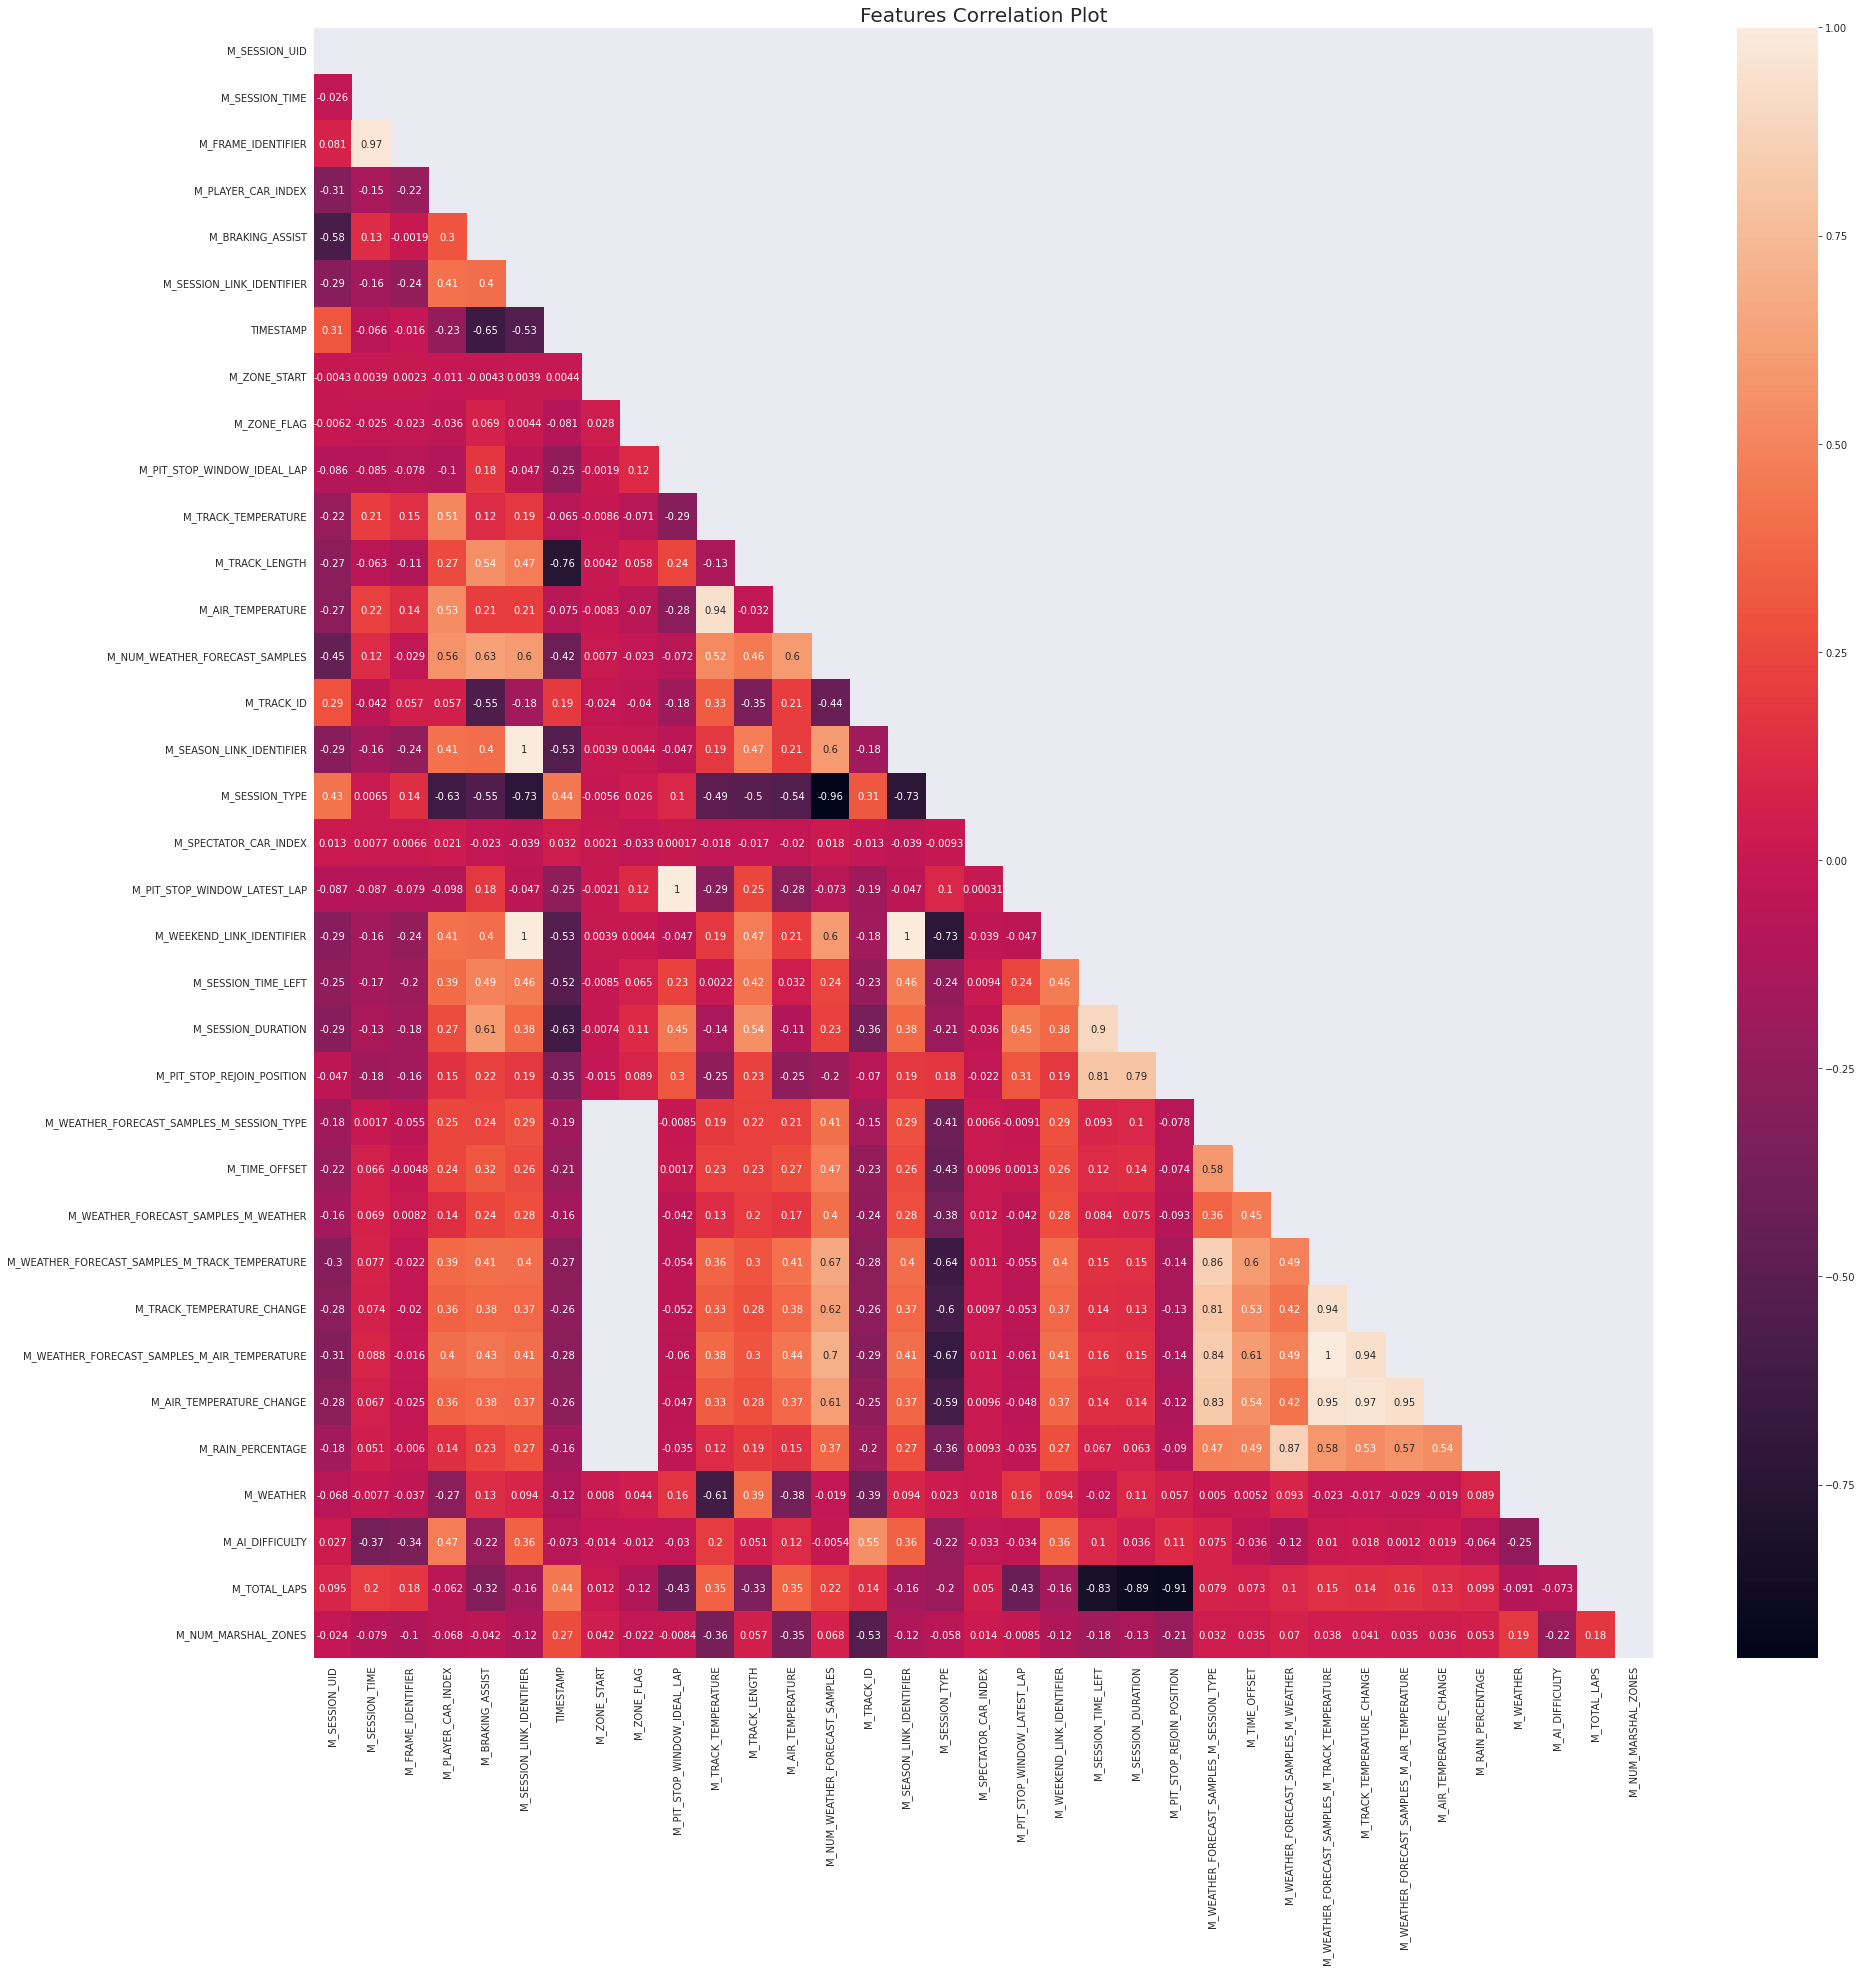

In [12]:
#A Function to Plot Heatmap of features
def Heatmap_Plot(data_mat):
    mask=np.zeros_like(data_mat)
    mask[np.triu_indices_from(mask)] =True
    plt.figure(figsize=(30,30))
    plt.title('Features Correlation Plot',size=20)
    sns.heatmap(data_mat,mask=mask,annot=True)
# Implementing Heatmap_Plot Function
Heatmap_Plot(corr_mat)

A Heatmap showing Correlation among Variables is shown above. Our Main variable of interest is M_RAIN_PERCENTAGE which is a probabilistic value to be predicted and M_WEATHER which is a classification problem. The plot above shows that some unexpected variables have some correlations with the the variable M_RAIN_PERCENTAGE and M_WEATHER . Features that have a correlation value of above a chosen threshold will be retained while those with correlation values less than a chosen threshold will be dropped.

In [13]:
# Function to Filter Variables not Corrlelated with Selected Feature
def Drop_not_correlated(corr_data,feature,threshold_corr_val):
    not_corr_list=[]
    feature_corr=corr_data.loc[feature]
    for i,val in enumerate(feature_corr):
        if abs(val)<=threshold_corr_val:
            not_corr_list.append(feature_corr.index[i])
    return not_corr_list
Drop_not_correlated(corr_mat,'M_RAIN_PERCENTAGE',threshold_corr_val=0.08)

['M_SESSION_TIME',
 'M_FRAME_IDENTIFIER',
 'M_PIT_STOP_WINDOW_IDEAL_LAP',
 'M_SPECTATOR_CAR_INDEX',
 'M_PIT_STOP_WINDOW_LATEST_LAP',
 'M_SESSION_TIME_LEFT',
 'M_SESSION_DURATION',
 'M_AI_DIFFICULTY',
 'M_NUM_MARSHAL_ZONES']

In [14]:
# Drop Features that are not Linearly correlated with M_RAIN_PERCENTAGE
data.drop(Drop_not_correlated(corr_mat,'M_RAIN_PERCENTAGE',threshold_corr_val=0.08),axis=1,inplace=True) 
data.shape

(3572328, 26)

In [15]:
data.head(5)

,M_SESSION_UID,M_PLAYER_CAR_INDEX,M_BRAKING_ASSIST,M_SESSION_LINK_IDENTIFIER,TIMESTAMP,M_ZONE_START,M_ZONE_FLAG,M_TRACK_TEMPERATURE,M_TRACK_LENGTH,M_AIR_TEMPERATURE,...,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_TIME_OFFSET,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER,M_TOTAL_LAPS
0,1.300210e+19,0,0,0,1.642362e+09,0.088,0.0,33,4650,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,200.0
1,1.300210e+19,0,0,0,1.642362e+09,0.167,0.0,33,4650,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,200.0
2,1.300210e+19,0,0,0,1.642362e+09,0.238,0.0,33,4650,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,200.0
3,1.300210e+19,0,0,0,1.642362e+09,0.298,0.0,33,4650,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,200.0
4,1.300210e+19,0,0,0,1.642362e+09,0.353,0.0,33,4650,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,200.0


In [16]:
# Features Not Correlated with M_WEATHER
Drop_not_correlated(corr_mat,'M_WEATHER',0.02)

['M_SESSION_TIME',
 'M_ZONE_START',
 'M_NUM_WEATHER_FORECAST_SAMPLES',
 'M_SPECTATOR_CAR_INDEX',
 'M_SESSION_TIME_LEFT',
 'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE',
 'M_TIME_OFFSET',
 'M_TRACK_TEMPERATURE_CHANGE',
 'M_AIR_TEMPERATURE_CHANGE']

In [17]:
# Dropping Selected Features
data.drop(['M_ZONE_START','M_ZONE_FLAG'],axis=1,inplace=True) # Drops Selected Columns
data.shape

(3572328, 24)

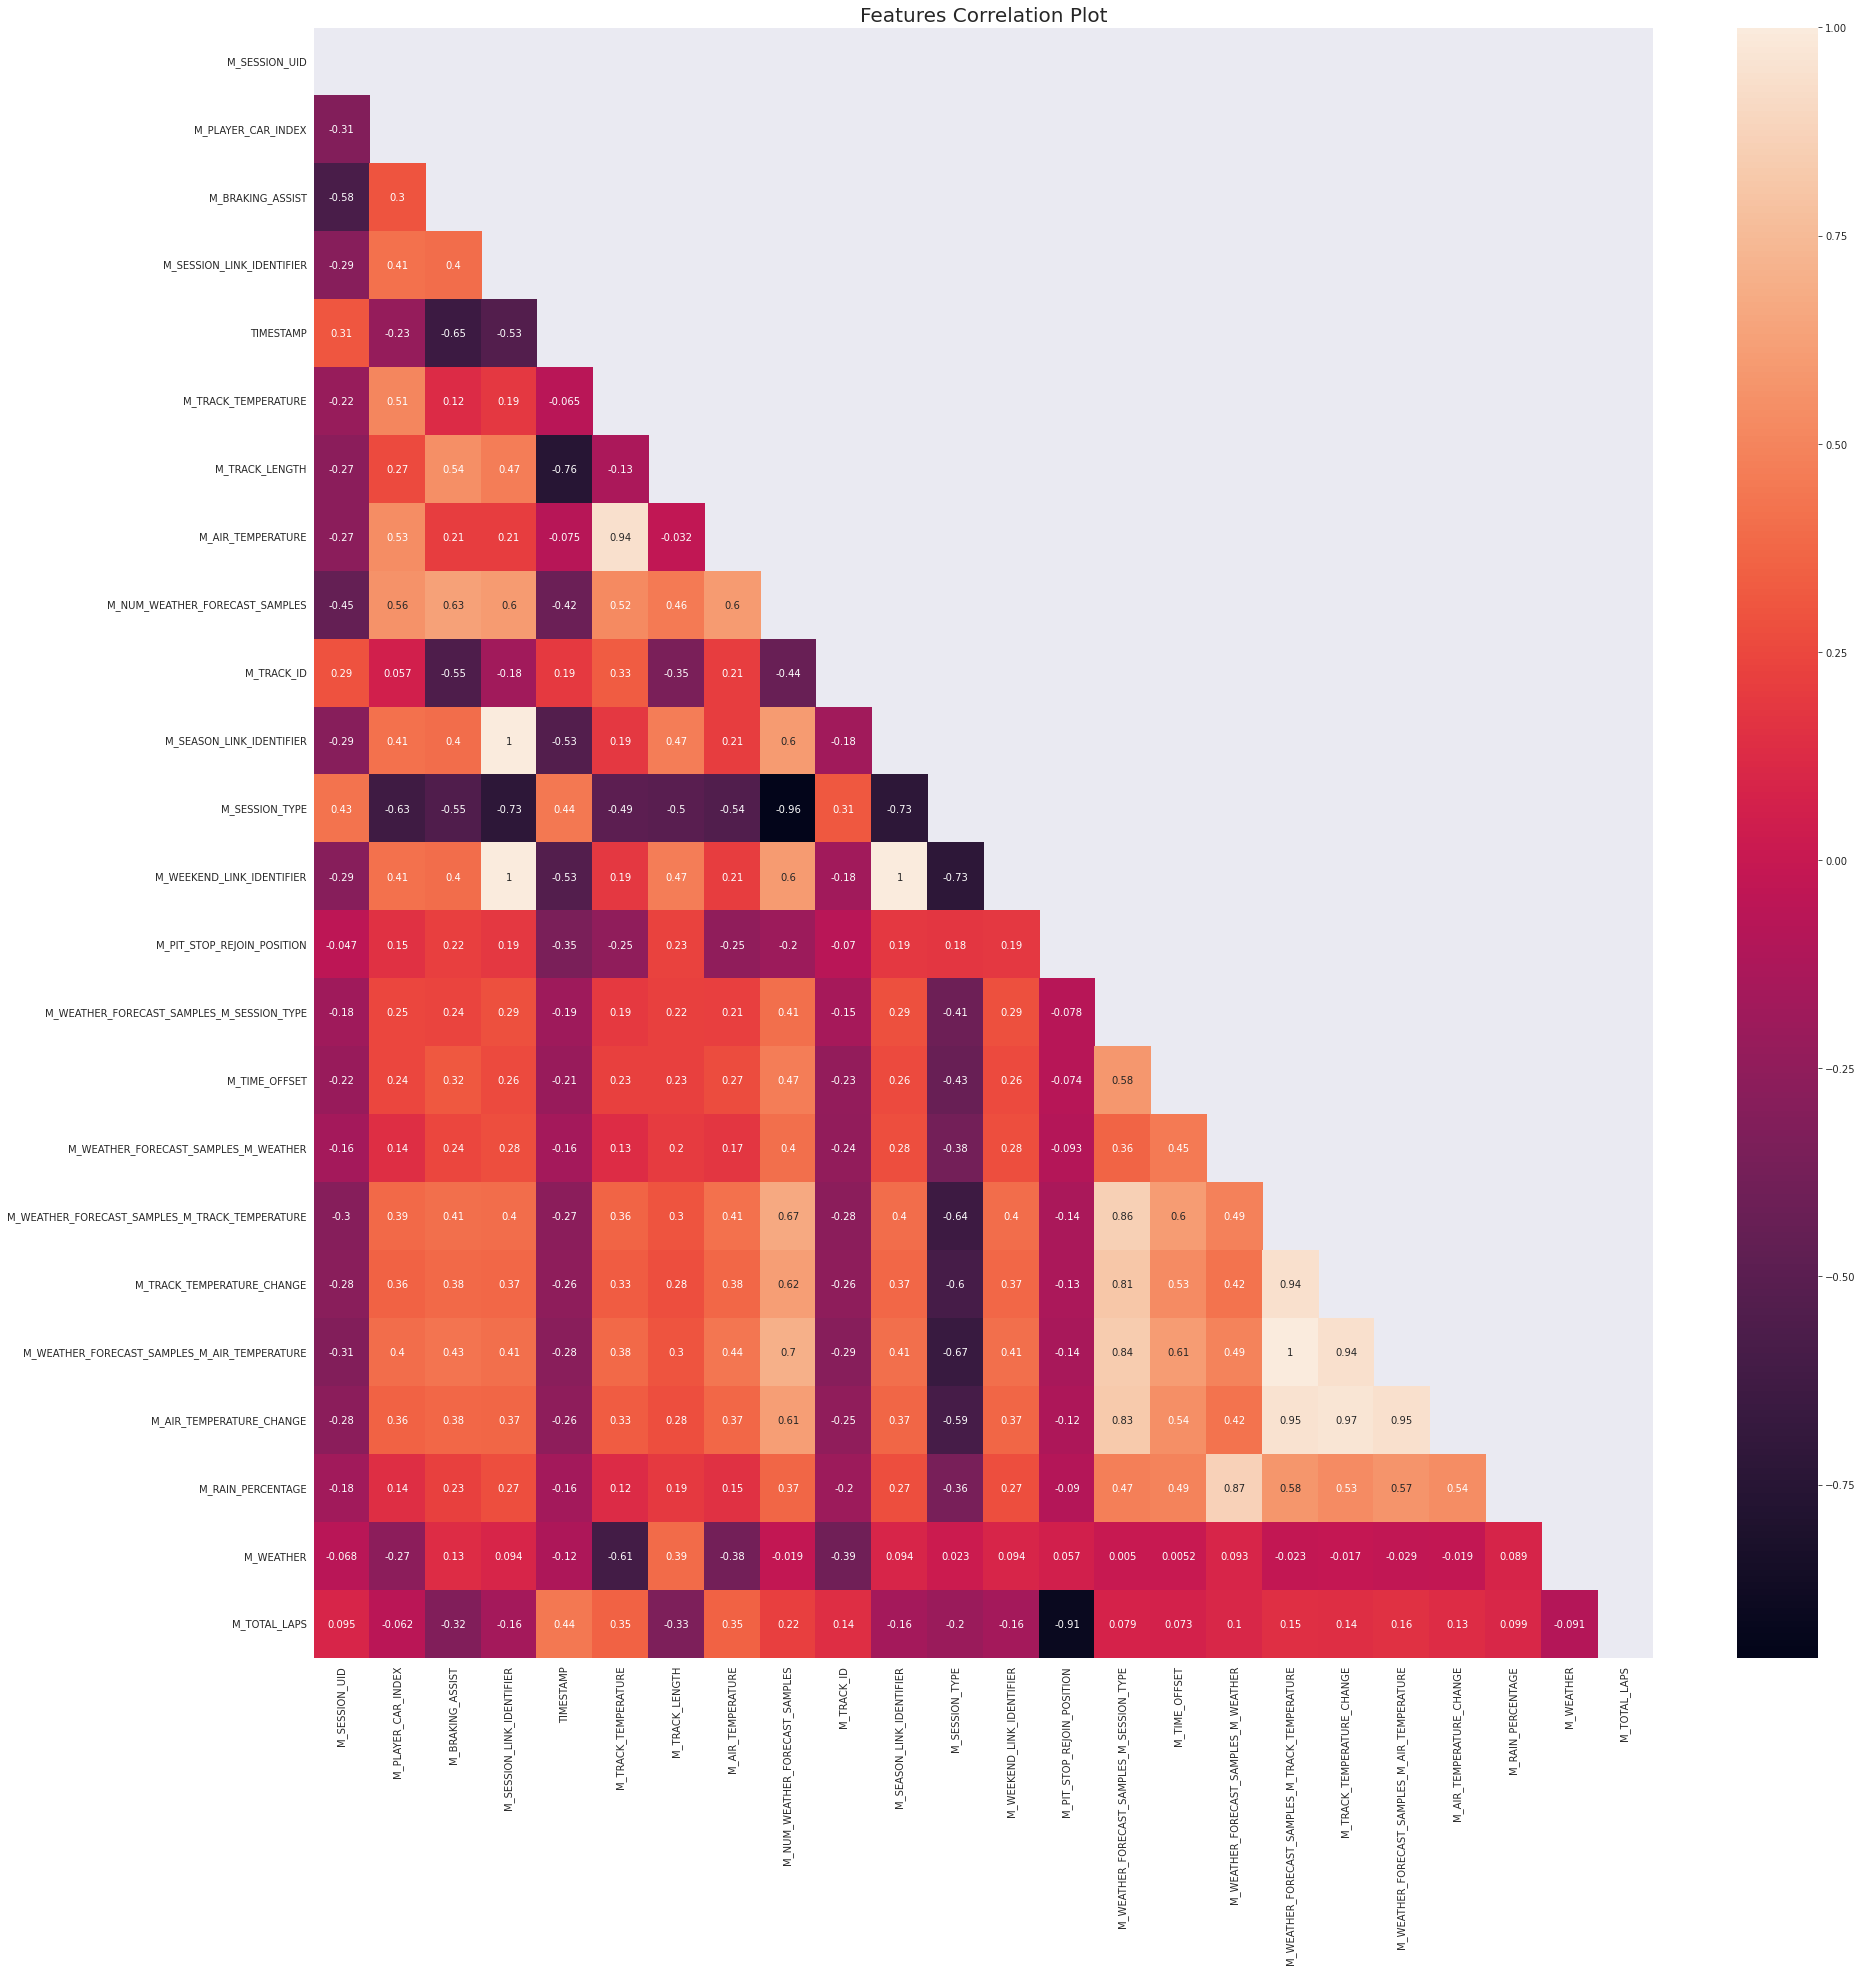

In [18]:
# Plotting Heatmap of Remaining Columns
Heatmap_Plot(data.corr())

### ROWS SELECTION

In [19]:
# Missing Entries in data
data.isnull().sum()

M_SESSION_UID                                          0
M_PLAYER_CAR_INDEX                                     0
M_BRAKING_ASSIST                                       0
M_SESSION_LINK_IDENTIFIER                              0
TIMESTAMP                                              0
M_TRACK_TEMPERATURE                                    0
M_TRACK_LENGTH                                         0
M_AIR_TEMPERATURE                                      0
M_NUM_WEATHER_FORECAST_SAMPLES                         0
M_TRACK_ID                                             0
M_SEASON_LINK_IDENTIFIER                               0
M_SESSION_TYPE                                         0
M_WEEKEND_LINK_IDENTIFIER                              0
M_PIT_STOP_REJOIN_POSITION                             0
M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE         974274
M_TIME_OFFSET                                     974274
M_WEATHER_FORECAST_SAMPLES_M_WEATHER              974274
M_WEATHER_FORECAST_SAMPLES_M_TR

In [20]:
# Missing Entries in data
data.isnull().sum()

M_SESSION_UID                                          0
M_PLAYER_CAR_INDEX                                     0
M_BRAKING_ASSIST                                       0
M_SESSION_LINK_IDENTIFIER                              0
TIMESTAMP                                              0
M_TRACK_TEMPERATURE                                    0
M_TRACK_LENGTH                                         0
M_AIR_TEMPERATURE                                      0
M_NUM_WEATHER_FORECAST_SAMPLES                         0
M_TRACK_ID                                             0
M_SEASON_LINK_IDENTIFIER                               0
M_SESSION_TYPE                                         0
M_WEEKEND_LINK_IDENTIFIER                              0
M_PIT_STOP_REJOIN_POSITION                             0
M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE         974274
M_TIME_OFFSET                                     974274
M_WEATHER_FORECAST_SAMPLES_M_WEATHER              974274
M_WEATHER_FORECAST_SAMPLES_M_TR

In [21]:
# Selecting only NUM_WEATHER_FORECAST_SAMPLES greater than 5
data=data[data.M_NUM_WEATHER_FORECAST_SAMPLES>=5]
data.shape

(2513039, 24)

Our AI Model is expected to predict 5 steps forward. Entries with less than than 5 Num of Samples to predict will not be useful to our model and has been dropped above

In [22]:
# Selecting Null Data Set only
offset_null=data[data.M_TIME_OFFSET.isnull()]
offset_null.head(5)

,M_SESSION_UID,M_PLAYER_CAR_INDEX,M_BRAKING_ASSIST,M_SESSION_LINK_IDENTIFIER,TIMESTAMP,M_TRACK_TEMPERATURE,M_TRACK_LENGTH,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_TRACK_ID,...,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_TIME_OFFSET,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER,M_TOTAL_LAPS
17017,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,200.0
17018,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,200.0
17019,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,200.0
17020,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,200.0
17021,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,200.0


From above, we pick a single feature that contains null values(M_OFFSET) and select all the subset of the data in that entry. this is to enable get a clearer picture of the way the null values are distributed accross the entire dataset

In [23]:
offset_null.isnull().sum() # Check the Number of Missing entries in the Offset_Null dataset

M_SESSION_UID                                          0
M_PLAYER_CAR_INDEX                                     0
M_BRAKING_ASSIST                                       0
M_SESSION_LINK_IDENTIFIER                              0
TIMESTAMP                                              0
M_TRACK_TEMPERATURE                                    0
M_TRACK_LENGTH                                         0
M_AIR_TEMPERATURE                                      0
M_NUM_WEATHER_FORECAST_SAMPLES                         0
M_TRACK_ID                                             0
M_SEASON_LINK_IDENTIFIER                               0
M_SESSION_TYPE                                         0
M_WEEKEND_LINK_IDENTIFIER                              0
M_PIT_STOP_REJOIN_POSITION                             0
M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE         685377
M_TIME_OFFSET                                     685377
M_WEATHER_FORECAST_SAMPLES_M_WEATHER              685377
M_WEATHER_FORECAST_SAMPLES_M_TR

The output above shows that same entries has null values in all features that contain missing values. Therefore we will drop any sample that has at least one missing value

In [24]:
# Dropping entries with missing entries
data.dropna(how='any',axis=0,inplace=True)
data.shape

(1827661, 24)

In [25]:
data.isnull().sum()

M_SESSION_UID                                     0
M_PLAYER_CAR_INDEX                                0
M_BRAKING_ASSIST                                  0
M_SESSION_LINK_IDENTIFIER                         0
TIMESTAMP                                         0
M_TRACK_TEMPERATURE                               0
M_TRACK_LENGTH                                    0
M_AIR_TEMPERATURE                                 0
M_NUM_WEATHER_FORECAST_SAMPLES                    0
M_TRACK_ID                                        0
M_SEASON_LINK_IDENTIFIER                          0
M_SESSION_TYPE                                    0
M_WEEKEND_LINK_IDENTIFIER                         0
M_PIT_STOP_REJOIN_POSITION                        0
M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE         0
M_TIME_OFFSET                                     0
M_WEATHER_FORECAST_SAMPLES_M_WEATHER              0
M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE    0
M_TRACK_TEMPERATURE_CHANGE                        0
M_WEATHER_FO

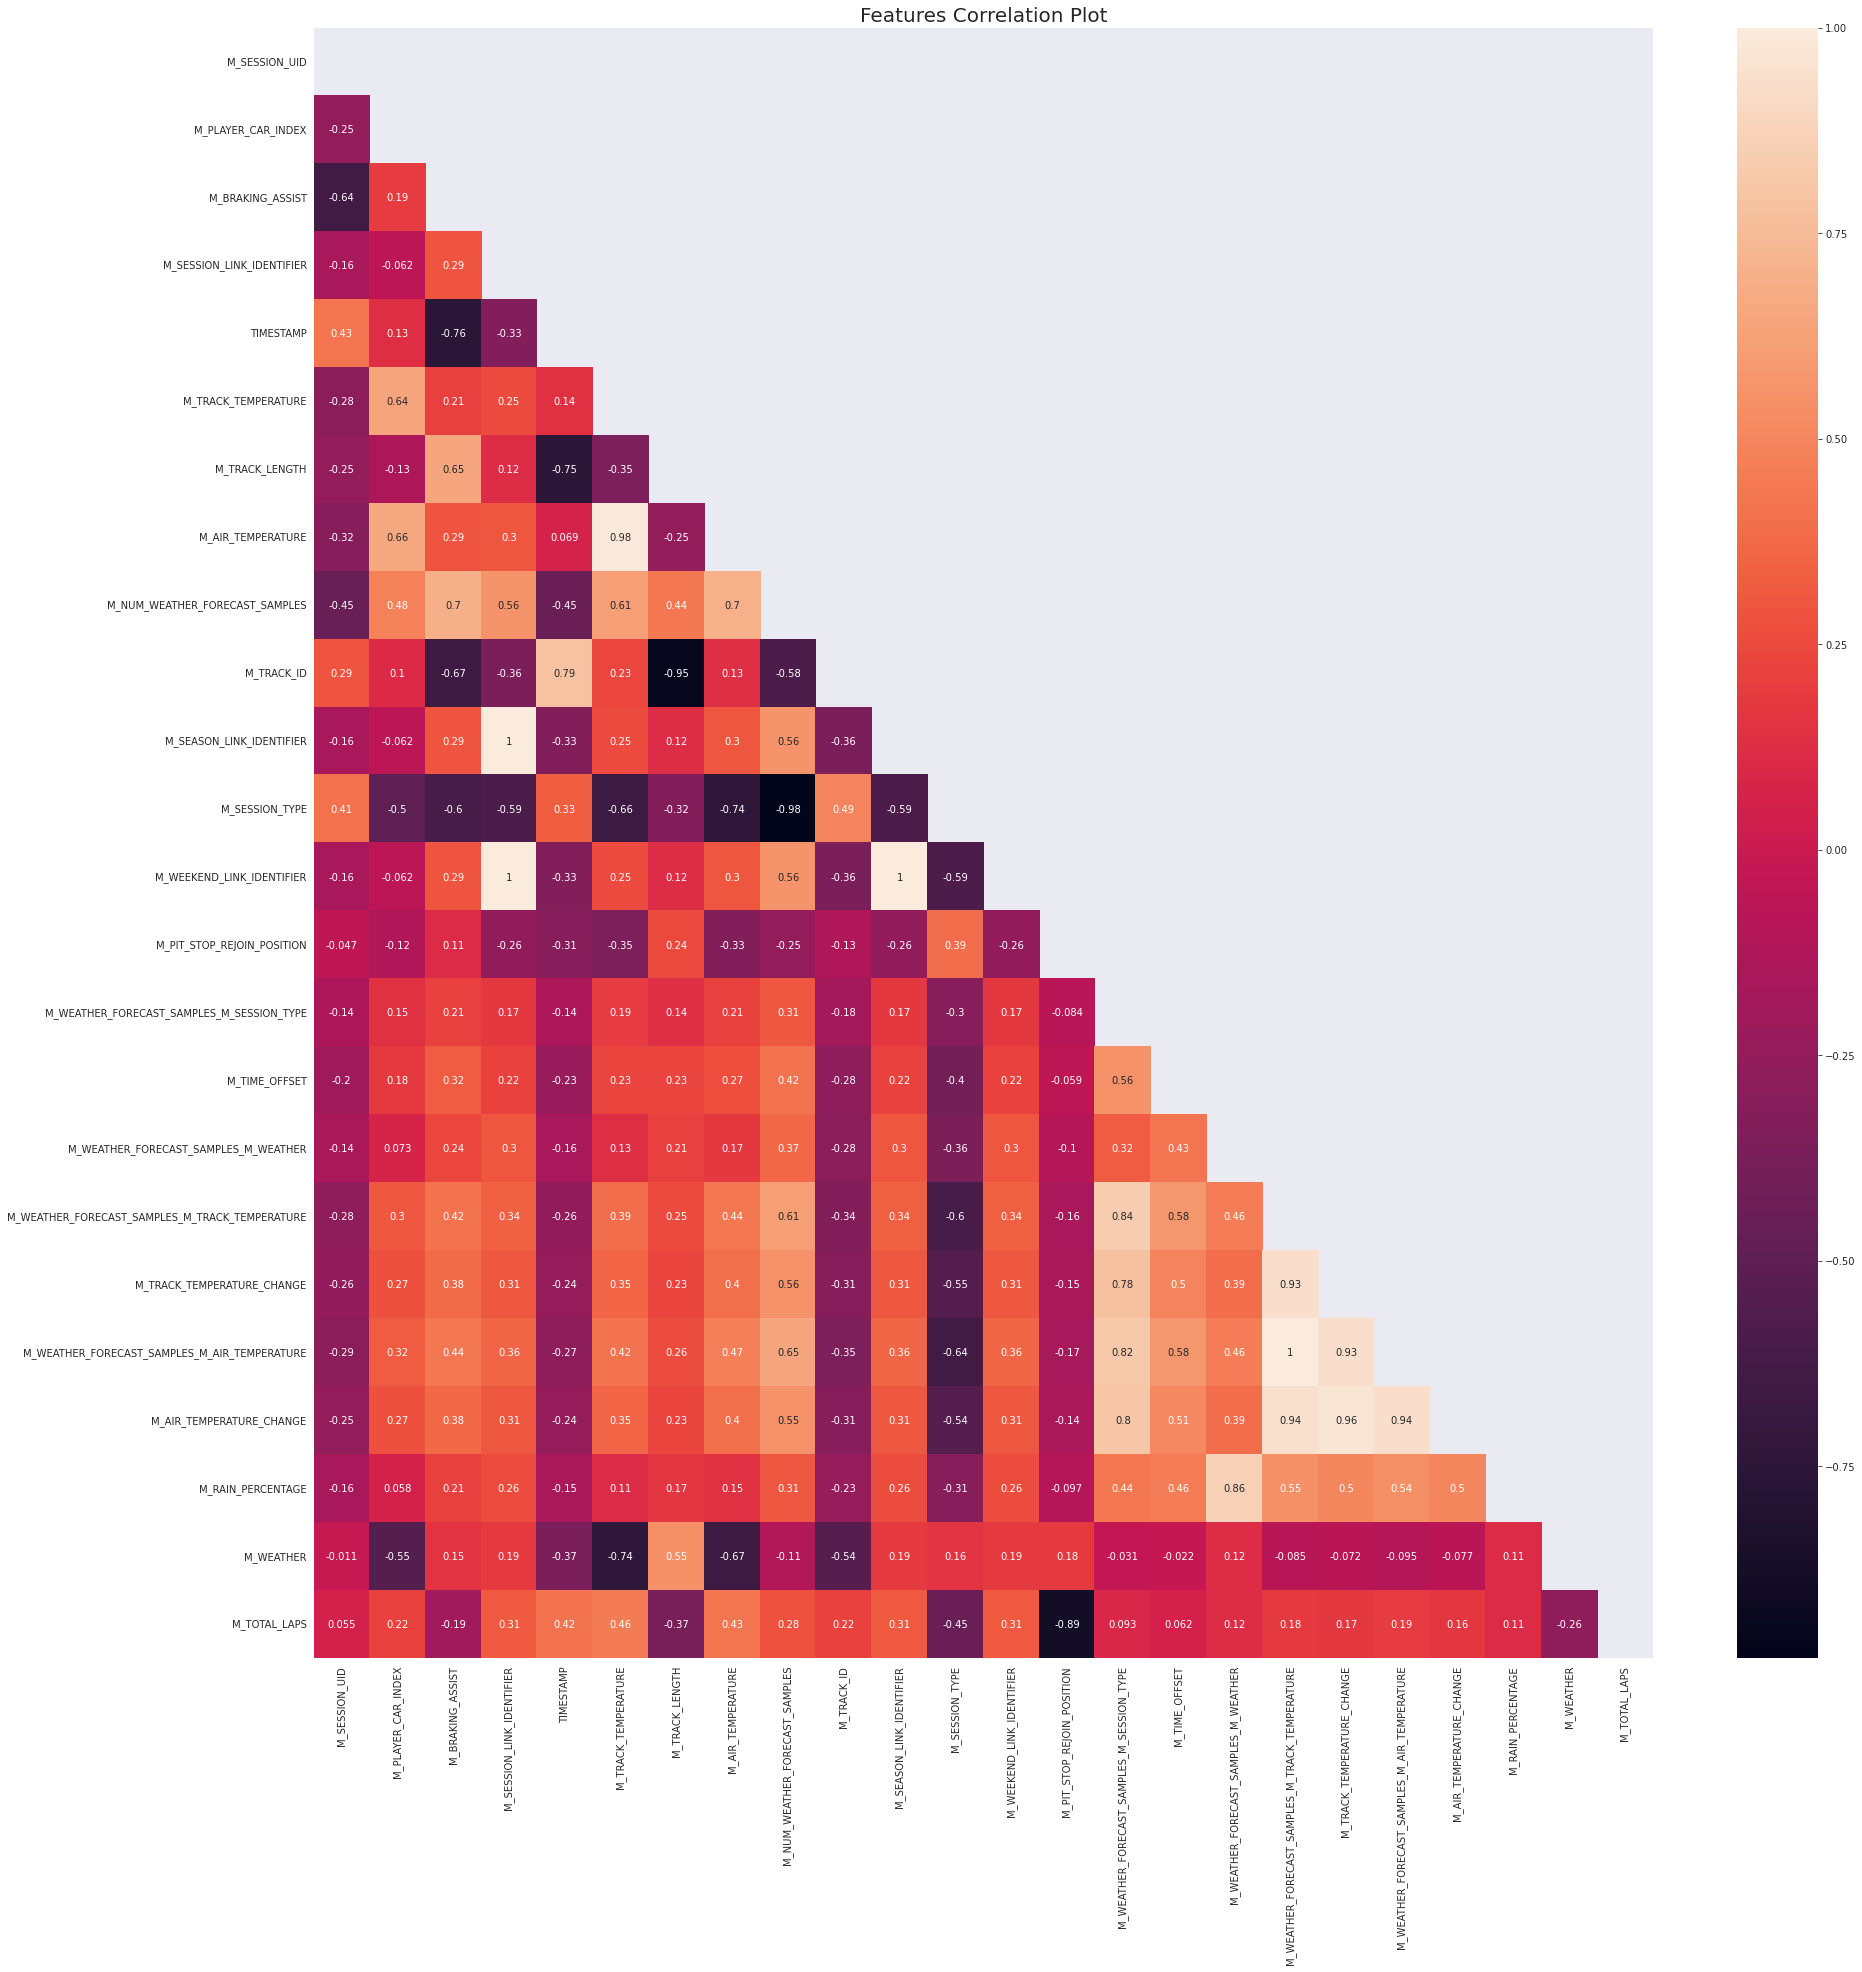

In [26]:
# View Updated Heatmap plot
Heatmap_Plot(data.corr())

In [27]:
# Check for Duplicated Data
data.duplicated().sum()

1159663

In [28]:
# A Peak at the Duplicated Data
dup_data=data[data.duplicated()]
dup_data.head(15)

,M_SESSION_UID,M_PLAYER_CAR_INDEX,M_BRAKING_ASSIST,M_SESSION_LINK_IDENTIFIER,TIMESTAMP,M_TRACK_TEMPERATURE,M_TRACK_LENGTH,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_TRACK_ID,...,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_TIME_OFFSET,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER,M_TOTAL_LAPS
17049,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,200.0
17050,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,200.0
17051,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,200.0
17052,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,200.0
17053,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,200.0
17054,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,200.0
17055,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,200.0
17056,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,200.0
17057,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,200.0
17058,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,200.0


The output above shows a portion of duplicated data,features such as SESSION_UID,PLAYER_CAR_INDEX,TIMESTAMP,RAIN_TEMPERATURE are also duplicated in the dataset.

1. There are three expected unique variables in the dataset (SESSION_UID,PLAYER_CAR_INDEX and TIMESTAMP). Having samples with same(duplicated) three entries likely indicates that these may be same samples entered into the dataset multiple times probably via different servers
2. Entries with large duplicated target variable will not be informative for our AI model and may likely skew the dataset if usch duplicated entries are much as in this case. There are over 1150000+ entries of zero in the duplicated dataset. This large number of same target entry will cause our data to be unbalanced and pose challenges to our model.

we will drop these duplicated rows

In [29]:
# Dropping Duplicated Rows
data.drop_duplicates(inplace=True)
data.shape

(667998, 24)

In [30]:
data.head(10)

,M_SESSION_UID,M_PLAYER_CAR_INDEX,M_BRAKING_ASSIST,M_SESSION_LINK_IDENTIFIER,TIMESTAMP,M_TRACK_TEMPERATURE,M_TRACK_LENGTH,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_TRACK_ID,...,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_TIME_OFFSET,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER,M_TOTAL_LAPS
17038,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,8.0,0.0,0.0,33.0,2.0,25.0,2.0,1.0,0,200.0
17039,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,8.0,5.0,0.0,33.0,2.0,25.0,2.0,1.0,0,200.0
17040,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,8.0,10.0,0.0,33.0,2.0,25.0,2.0,2.0,0,200.0
17041,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,0.0,1.0,32.0,1.0,24.0,1.0,5.0,0,200.0
17042,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,5.0,1.0,32.0,2.0,24.0,2.0,5.0,0,200.0
17043,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,10.0,1.0,32.0,2.0,24.0,2.0,5.0,0,200.0
17044,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,15.0,1.0,32.0,2.0,24.0,2.0,7.0,0,200.0
17045,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,30.0,1.0,31.0,1.0,24.0,2.0,17.0,0,200.0
17046,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,45.0,1.0,31.0,2.0,23.0,1.0,6.0,0,200.0
17047,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,60.0,1.0,30.0,1.0,23.0,2.0,4.0,0,200.0


In [31]:
# Unique TimeStamps
data.TIMESTAMP.value_counts()

1.642374e+09    60
1.642374e+09    60
1.642374e+09    60
1.642374e+09    60
1.642374e+09    60
                ..
1.641392e+09     7
1.641392e+09     7
1.641392e+09     7
1.641392e+09     7
1.641392e+09     7
Name: TIMESTAMP, Length: 31961, dtype: int64

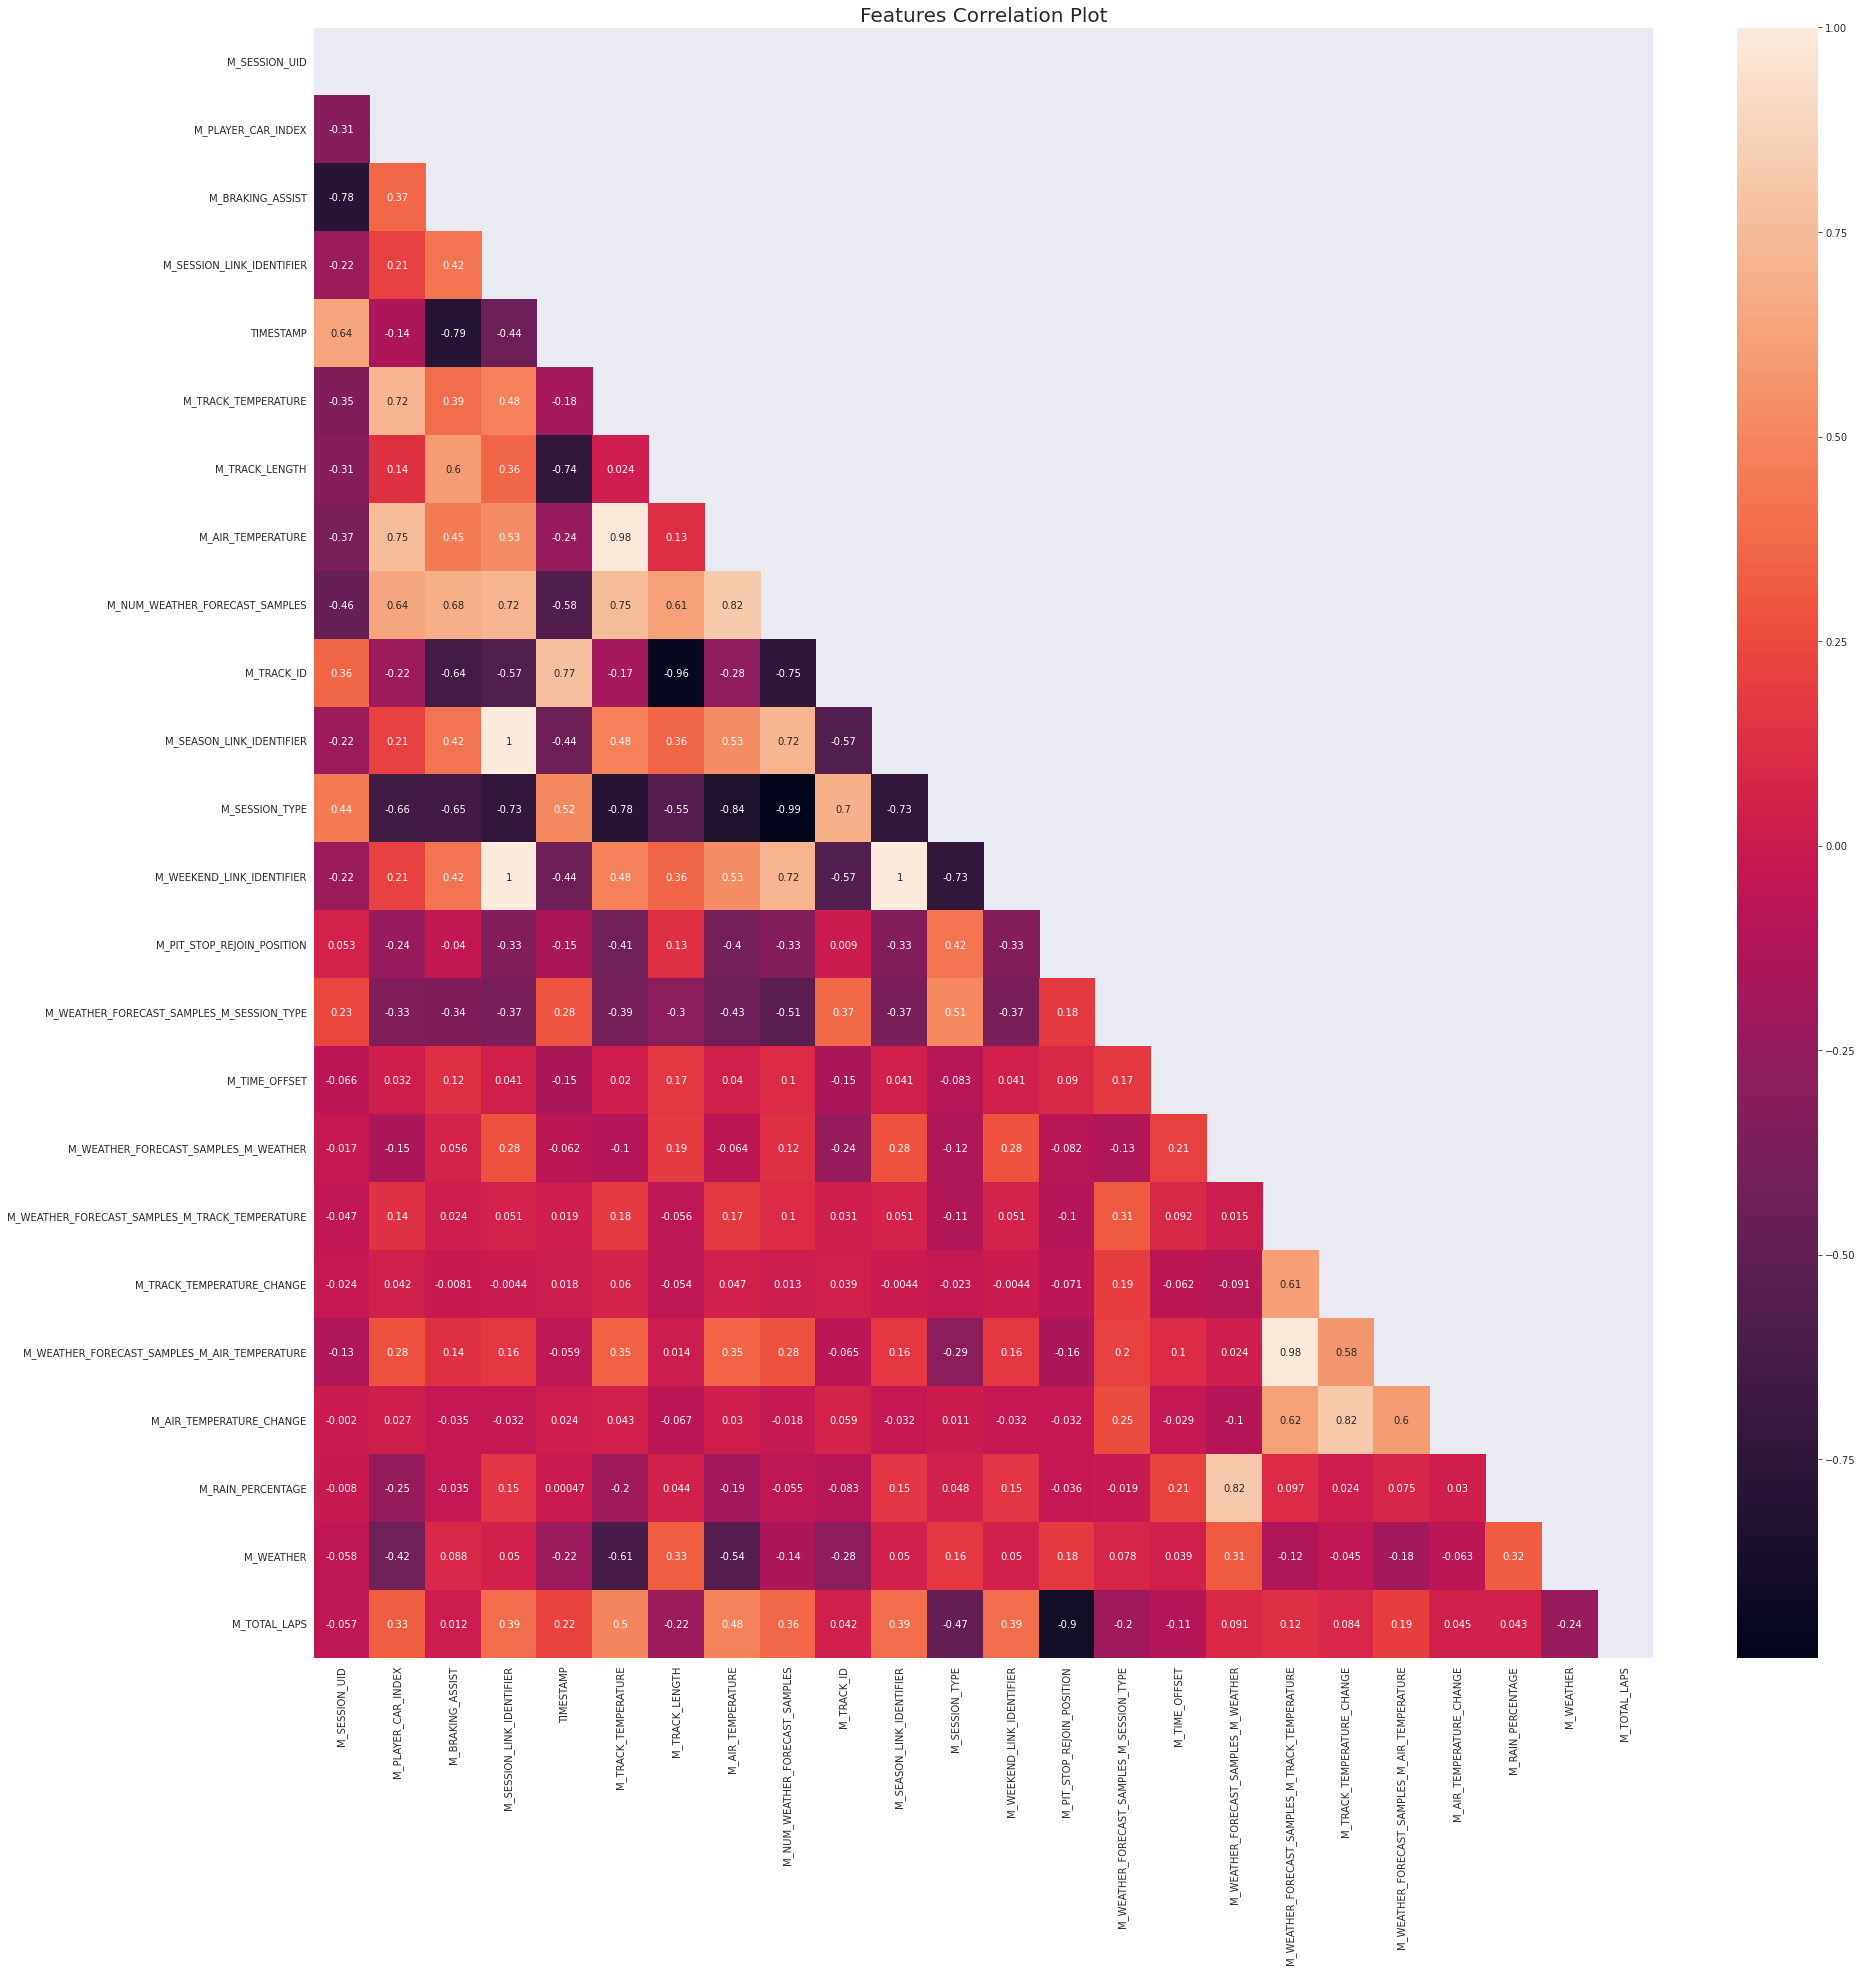

In [32]:
# HeatMap of Updated Data
Heatmap_Plot(data.corr())

In [33]:
data.M_PLAYER_CAR_INDEX.value_counts()

19    527793
0      62572
1      41547
2      35540
6        546
Name: M_PLAYER_CAR_INDEX, dtype: int64

In [34]:
# Checking for Multiple Player_Index for a given Session
for x in range(115):
    print(data[data.M_SESSION_UID.isin([data.M_SESSION_UID.value_counts().index[x]])].M_PLAYER_CAR_INDEX.value_counts()) # This iterates over the sessions and prints the value counts of the PLAYER_CAR_INDEX
    print()

19    316050
Name: M_PLAYER_CAR_INDEX, dtype: int64

19    56840
Name: M_PLAYER_CAR_INDEX, dtype: int64

1    41107
Name: M_PLAYER_CAR_INDEX, dtype: int64

19    26558
Name: M_PLAYER_CAR_INDEX, dtype: int64

2    14980
Name: M_PLAYER_CAR_INDEX, dtype: int64

2    14710
Name: M_PLAYER_CAR_INDEX, dtype: int64

0    12463
Name: M_PLAYER_CAR_INDEX, dtype: int64

0    12386
Name: M_PLAYER_CAR_INDEX, dtype: int64

0    12122
Name: M_PLAYER_CAR_INDEX, dtype: int64

19    8096
Name: M_PLAYER_CAR_INDEX, dtype: int64

0    7370
Name: M_PLAYER_CAR_INDEX, dtype: int64

0    6809
Name: M_PLAYER_CAR_INDEX, dtype: int64

0    5940
Name: M_PLAYER_CAR_INDEX, dtype: int64

2    5600
Name: M_PLAYER_CAR_INDEX, dtype: int64

0    5346
Name: M_PLAYER_CAR_INDEX, dtype: int64

19    5096
Name: M_PLAYER_CAR_INDEX, dtype: int64

19    4480
Name: M_PLAYER_CAR_INDEX, dtype: int64

19    3839
Name: M_PLAYER_CAR_INDEX, dtype: int64

19    3278
Name: M_PLAYER_CAR_INDEX, dtype: int64

19    3190
Name: M_PLAYER_CAR_IN

The cell above shows that here are no multiple PLAYER_CAR_INDEX for every session so there is no possiblity of having multiple players having same data entry into the updated datset

In [35]:
# Checking for duplicated TIMESTAMP ENTRY
print('There are {} duplicated TIMESTAMP entry'.format(data.TIMESTAMP.duplicated().sum()))
print('There are {} unique TIMESTAMP entry'.format(data[data.TIMESTAMP.duplicated()==False].shape[0]))

There are 636037 duplicated TIMESTAMP entry
There are 31961 unique TIMESTAMP entry


In [36]:
# A peek at Timestamp Uique Value
data.M_TIME_OFFSET[data.TIMESTAMP.duplicated()==False].value_counts() # Count of TIME OFFSET in Unique TIMESTAMP entries

0.0    31961
Name: M_TIME_OFFSET, dtype: int64

TIMESTEPS of 0.0 indicates Ground Truth and Not Prediction. The Output above shows that there are 31961 ground truths, the rest of the entries are predictions for different timestamps and these constitute the Unique Values in TIMESTAMP

In [37]:
data.head(20)

,M_SESSION_UID,M_PLAYER_CAR_INDEX,M_BRAKING_ASSIST,M_SESSION_LINK_IDENTIFIER,TIMESTAMP,M_TRACK_TEMPERATURE,M_TRACK_LENGTH,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_TRACK_ID,...,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_TIME_OFFSET,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER,M_TOTAL_LAPS
17038,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,8.0,0.0,0.0,33.0,2.0,25.0,2.0,1.0,0,200.0
17039,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,8.0,5.0,0.0,33.0,2.0,25.0,2.0,1.0,0,200.0
17040,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,8.0,10.0,0.0,33.0,2.0,25.0,2.0,2.0,0,200.0
17041,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,0.0,1.0,32.0,1.0,24.0,1.0,5.0,0,200.0
17042,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,5.0,1.0,32.0,2.0,24.0,2.0,5.0,0,200.0
17043,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,10.0,1.0,32.0,2.0,24.0,2.0,5.0,0,200.0
17044,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,15.0,1.0,32.0,2.0,24.0,2.0,7.0,0,200.0
17045,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,30.0,1.0,31.0,1.0,24.0,2.0,17.0,0,200.0
17046,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,45.0,1.0,31.0,2.0,23.0,1.0,6.0,0,200.0
17047,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,60.0,1.0,30.0,1.0,23.0,2.0,4.0,0,200.0


In [38]:
# Selecting only 0,5,10,15,30,60 TIME_OFFSETs
data=data[data.M_TIME_OFFSET.isin([0,5,10,15,30,60])]
data.shape

(586446, 24)

In [39]:
data.M_TIME_OFFSET.values.shape

(586446,)

In [40]:
# Function to Filter TIME_OFFSET Feature and Select only TIME OFFSETS spaning 60 Mins
def Offset_filter(data): # Recieves an array of the Data as Input
    ind_list=[];temp_list=[];Count=0 
    for i in range(len(data)):
        if data[i]==0:
            Count=0;temp_list=[];temp_list.append(i) # If entry into Offset is zero it begins to count and makes an initial empty list
            continue # Avoid looping further and goes to next value if condition is met
        Count+=1;temp_list.append(i) # append a count of 1 if entry not equals to 0 and appends the position to a list
        if data[i]==60 and Count==5: # If data entry is 60 and it has counted 5 values it performs the following actions
            ind_list.append(temp_list) # appends the temp array list to a final list . This is the list of Data points we actually need to extract
            temp_list=[];Count=0
    return np.array(ind_list) # Returns the Output as an array
Offset_filter(data.M_TIME_OFFSET.values)[:10]

array([[ 3,  4,  5,  6,  7,  8],
       [13, 14, 15, 16, 17, 18],
       [23, 24, 25, 26, 27, 28],
       [33, 34, 35, 36, 37, 38],
       [43, 44, 45, 46, 47, 48],
       [53, 54, 55, 56, 57, 58],
       [63, 64, 65, 66, 67, 68],
       [73, 74, 75, 76, 77, 78],
       [83, 84, 85, 86, 87, 88],
       [93, 94, 95, 96, 97, 98]])

These are the index Locations we need in the dataset

In [41]:
# Flatten The array
offset_index=Offset_filter(data.M_TIME_OFFSET.values).flatten()
print('Selected Number of Points: {}'.format(offset_index.shape))
# Select the indexes from the Datasets
data=data.iloc[offset_index,:]
data.shape

Selected Number of Points: (495918,)


(495918, 24)

In [42]:
data.head(20)

,M_SESSION_UID,M_PLAYER_CAR_INDEX,M_BRAKING_ASSIST,M_SESSION_LINK_IDENTIFIER,TIMESTAMP,M_TRACK_TEMPERATURE,M_TRACK_LENGTH,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_TRACK_ID,...,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_TIME_OFFSET,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER,M_TOTAL_LAPS
17041,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,0.0,1.0,32.0,1.0,24.0,1.0,5.0,0,200.0
17042,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,5.0,1.0,32.0,2.0,24.0,2.0,5.0,0,200.0
17043,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,10.0,1.0,32.0,2.0,24.0,2.0,5.0,0,200.0
17044,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,15.0,1.0,32.0,2.0,24.0,2.0,7.0,0,200.0
17045,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,30.0,1.0,31.0,1.0,24.0,2.0,17.0,0,200.0
17047,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,60.0,1.0,30.0,1.0,23.0,2.0,4.0,0,200.0
17118,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,0.0,1.0,32.0,1.0,24.0,1.0,5.0,0,200.0
17119,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,5.0,1.0,32.0,2.0,24.0,2.0,5.0,0,200.0
17120,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,10.0,1.0,32.0,2.0,24.0,2.0,5.0,0,200.0
17121,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,15.0,1.0,32.0,2.0,24.0,2.0,7.0,0,200.0


In [43]:
# Checking for Duplicated Entires
print('Number of Duplicated Entries is {}'.format(data.duplicated().sum()))

Number of Duplicated Entries is 0


In [44]:
data.M_WEATHER.value_counts()

0    350676
1    137766
2      7476
Name: M_WEATHER, dtype: int64

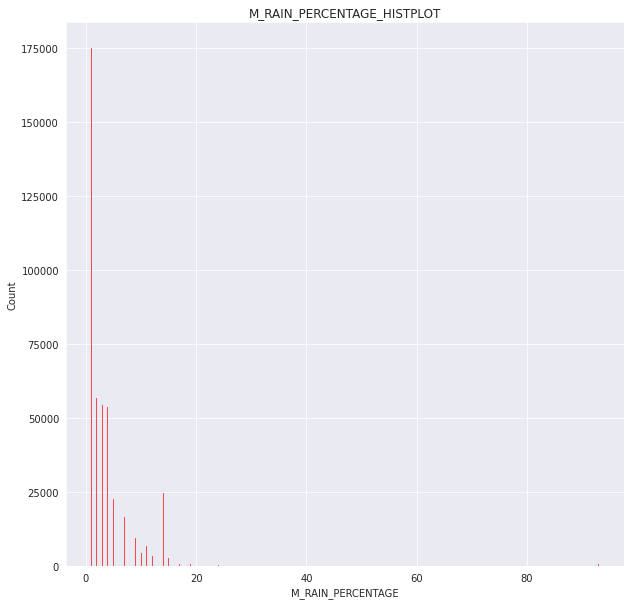

In [45]:
#Histogram Plot
def Hist_plot(data,feature,feature_plot_name,color='r'):
    plt.figure(figsize=(10,10))
    plt.title(feature_plot_name)
    sns.histplot(data[feature],color=color)
Hist_plot(data,'M_RAIN_PERCENTAGE','M_RAIN_PERCENTAGE_HISTPLOT')


/opt/conda/lib/python3.6/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='M_RAIN_PERCENTAGE'>

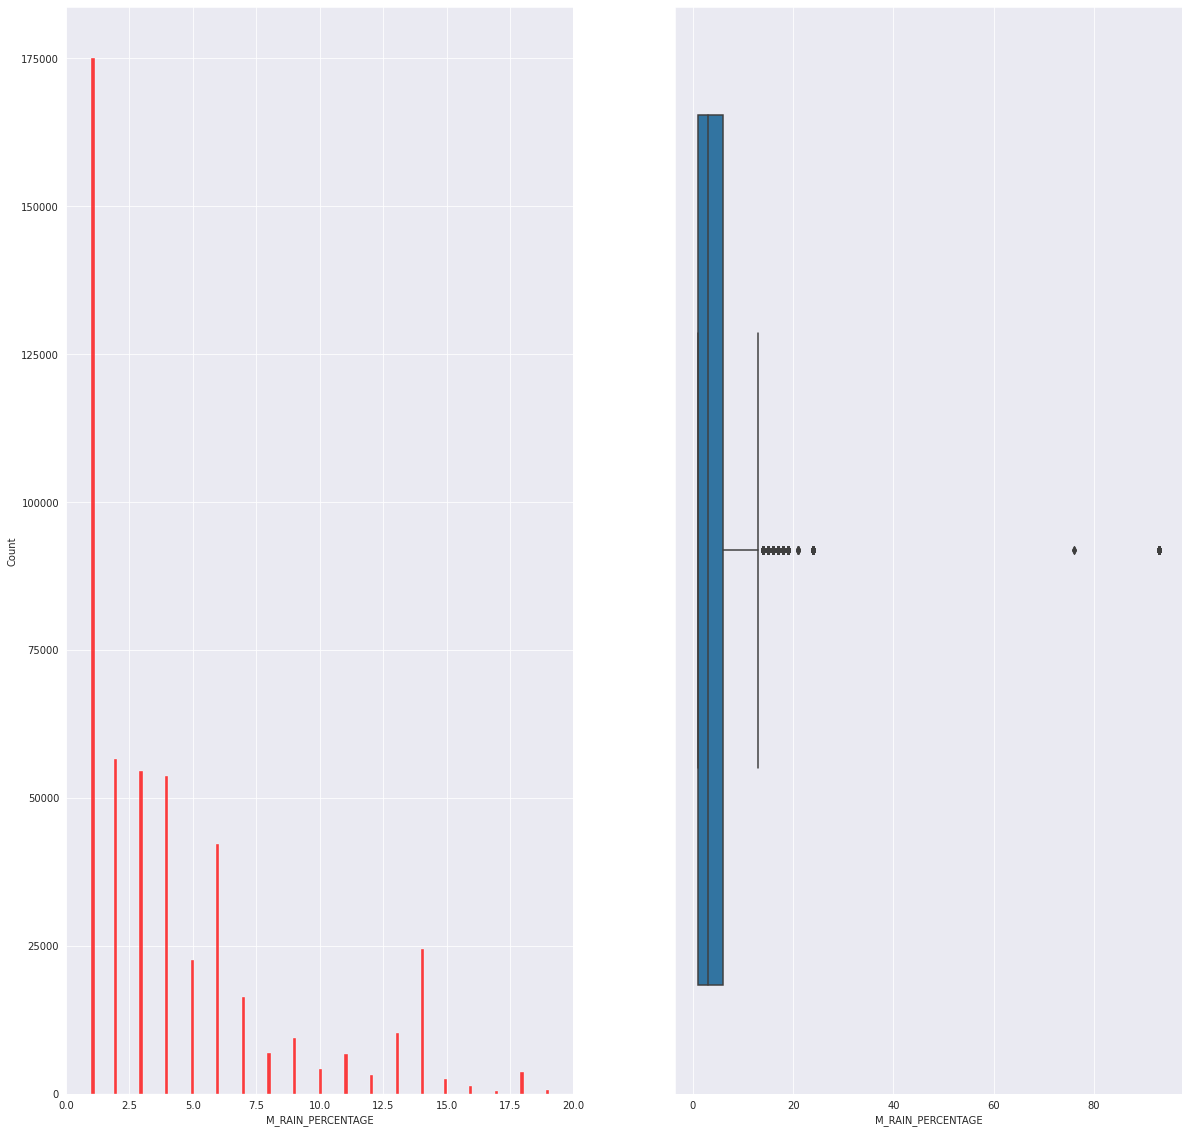

In [46]:
# Plot Of Rain Percentage
plt.figure(figsize=(20,20))
plt.title('Rain Percentage Hist Plot',size=20)
plt.subplot(1,2,1)
plt.xlim(0,20)
sns.histplot(x=data.M_RAIN_PERCENTAGE,color='r')
plt.subplot(1,2,2)
sns.boxplot(x=data.M_RAIN_PERCENTAGE,orient='v')

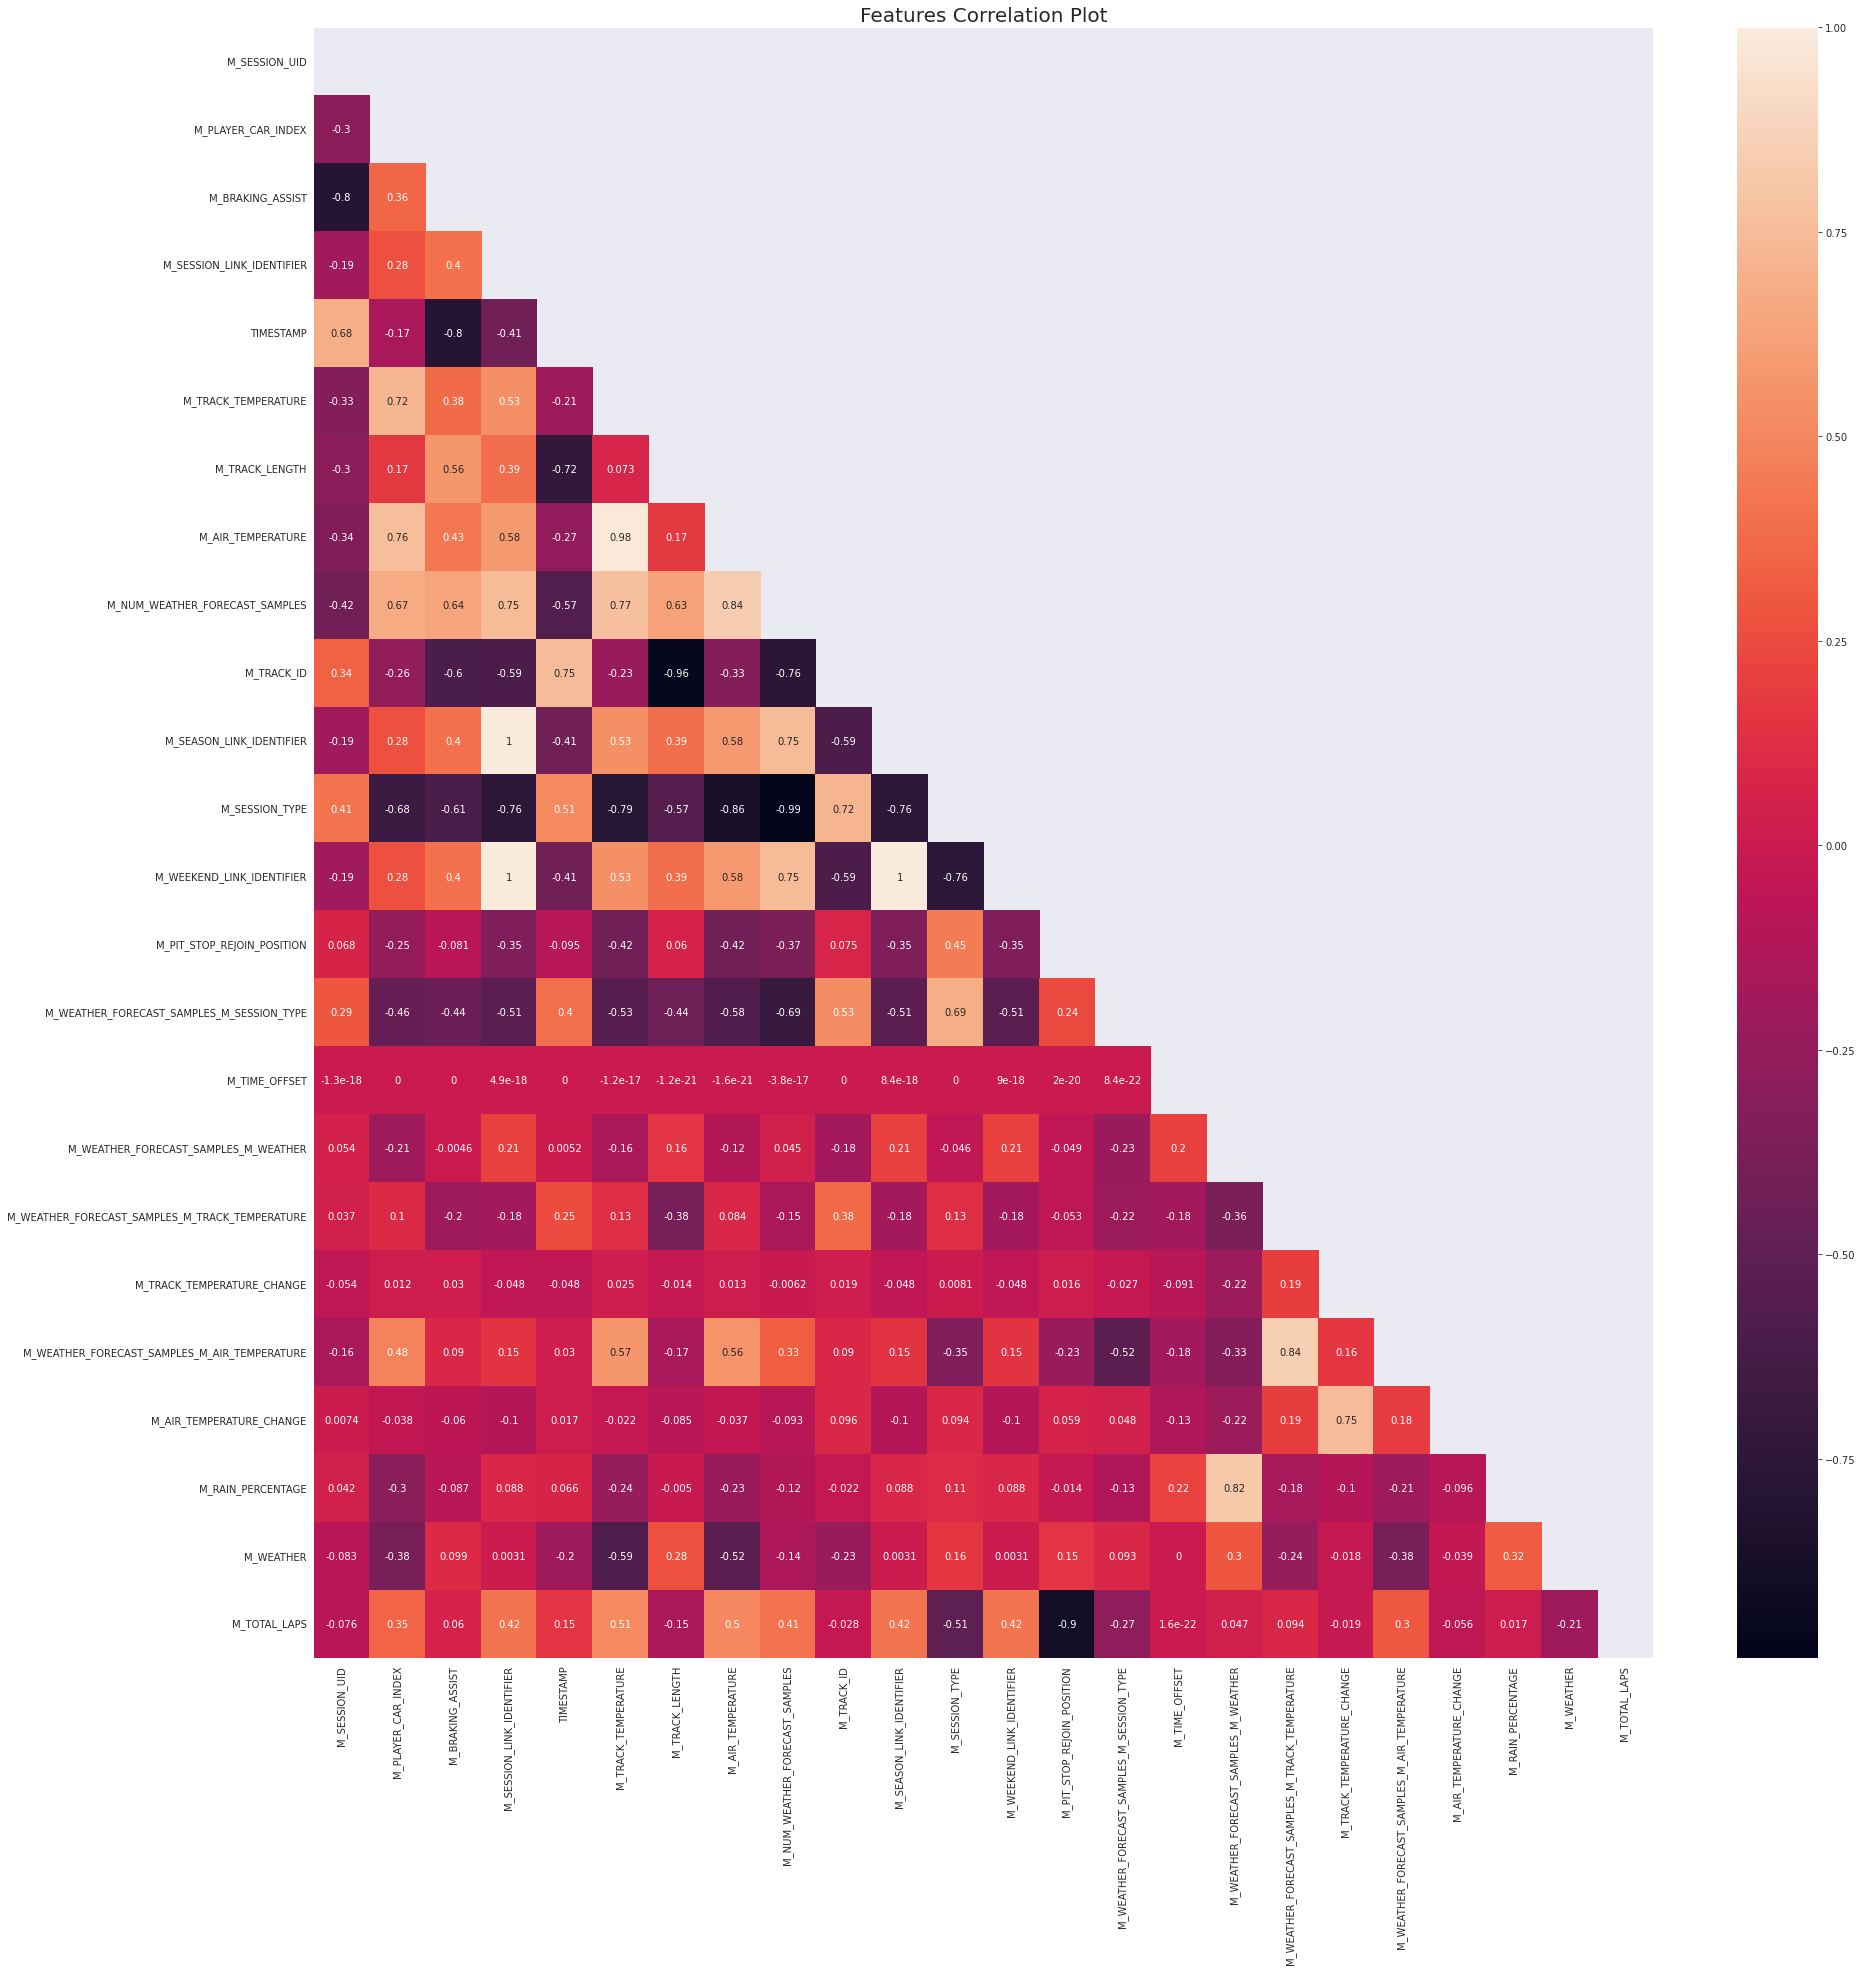

In [47]:
# HeatMap of Updated \features
Heatmap_Plot(data.corr())

Much of the features are showing weaker correlation to the Target Variable After the Data Cleaning and Pruning Compared to earlier plots. This can be seen from the plot above

In [48]:
Drop_not_correlated(data.corr(),'M_RAIN_PERCENTAGE',0.08)

['M_SESSION_UID',
 'TIMESTAMP',
 'M_TRACK_LENGTH',
 'M_TRACK_ID',
 'M_PIT_STOP_REJOIN_POSITION',
 'M_TOTAL_LAPS']

In [49]:
i=6;b=[]
for x in range(0,len(data)-i,6):
    b.append(data['M_WEATHER'][x:x+i].sum())
pd.Series(b).value_counts()

0     58445
6     22961
12     1246
dtype: int64

In [50]:
# Downsizing the Entries
unique_data=data[data.TIMESTAMP.duplicated()==False]
unique_data.M_WEATHER.value_counts()

0    21026
1     9665
2     1192
Name: M_WEATHER, dtype: int64

In [51]:
zero_list=unique_data[unique_data.M_WEATHER.isin([0])]
zero_list.M_RAIN_PERCENTAGE.value_counts()

3.0     7155
1.0     6974
2.0     4374
4.0     1516
5.0      752
15.0     228
6.0       27
Name: M_RAIN_PERCENTAGE, dtype: int64

The Plot of the Dataset and cells above shows that the cleaned dataset is unbalanced and heavily skewed, if used to predict out model this can impact it adversely by making it to memorize the majority class and fail to predict the minority class. we seek to balance the dataset. there are certains considerations we take into place before balancing the dataset these are:

1. This is a timeseries data with sequence by sequence entry. This makes it inappropriate to randomly drop the instances of majority class

2. The CEll 47 above shows that most of the majority entries in the sequences are zero i.e the ground truth is zero and the predictions for that time frame is also zero. This is an abundant of redundant data that will make no meaning to our AI model and may negatively impact our model.

3. The cell above shows That for the majority class of WEATHER i.e WEATHER=ZERO there are also imbalanced number of RAIN_PERCENTAGE. dropping these entries randomly may make us lose information about these sub minority clases 

We will deploy some careful but manual techniques to select the necessary timesteps so as to presereve the info in the clean dataset

In [52]:
# Function to extract the timestamp series that is needed
def Timestamp_extract(unique_data_timestamp,weather_class,rain_pred_class,num_samples_required):
    extract_data=unique_data_timestamp[unique_data_timestamp.M_WEATHER.isin([weather_class])] # This extracts the Weather class from the unique_timestamp_data
    extract_data=extract_data.TIMESTAMP[extract_data.M_RAIN_PERCENTAGE.isin([rain_pred_class])][:num_samples_required]
    return extract_data.values
    

The Fuction above Extracts TIMESTAMP Values from the Unique TIMESTAMPS dataframe. it takes as input as data frame of unique TIMESTAMPS, the weather class to be extracted, the rain_prediction class to be extracted from the subset data of the selected weather_class and the number of samples that we want to extract for that weather class. This Function will help us to preserve the information in the majority weather classes while reducing them. it will return a 1D array of the selected Timestamp. This will then be appended to list that will hold all the Timeseries we will use for preparing our model. 

In [53]:
# Extracting TimeStamps For Weather Class 0
timestamps_list=[] # An Empty list that will be populated with our extracted timestamps
for x,y in zip([3.0,1.0,2.0,4.0,5.0,15.0,6.0],[700,600,500,400,300,228,27]): # Iterates 2 list simulteanously using zip() First list=Rain_Prediction_Class, Second_list=Num_Samples_Required
    timestamps_list.append(Timestamp_extract(unique_data,0,x,y))
len(timestamps_list)

7

In [54]:
# Weather Class 1
unique_data.M_RAIN_PERCENTAGE[unique_data.M_WEATHER.isin([1])].value_counts()

4.0     2067
10.0    1898
5.0     1487
11.0    1290
14.0    1102
18.0     619
3.0      486
15.0     442
6.0      231
8.0       29
9.0       14
Name: M_RAIN_PERCENTAGE, dtype: int64

The Output above shows the Number of Rain Prediction in Weather Class One. we will extract some samples from them while trying to preserve the information and the distribution of classes

In [55]:
# Apply TIMESTAMP extract function to weather class One
for x,y in zip([3.0,4.0,5.0,11.0,10.0,18.0,6.0,8.0,9.0,14.0,15.0],[200,300,200,400,400,250,100,29,14,200,100]): # Iterates 2 list simulteanously using zip() First list=Rain_Prediction_Class, Second_list=Num_Samples_Required
    timestamps_list.append(Timestamp_extract(unique_data,1,x,y))
len(timestamps_list)

18

The Number Of Samples to extract were determined by weighing the Proportion of each entry in the overall Unique Dataset of the weather using Cell 81.  Values that have already appeared in weather class 0 were given lesser number of samples.

In [56]:
# Weather Class 2
unique_data.M_RAIN_PERCENTAGE[unique_data.M_WEATHER.isin([2])].value_counts()

16.0    1176
24.0       9
15.0       7
Name: M_RAIN_PERCENTAGE, dtype: int64

In [57]:
# Append TimeStamp of Weather class 2 to the list
timestamps_list.append(unique_data.TIMESTAMP[unique_data.M_WEATHER.isin([2])].values)
len(timestamps_list)

19

In [58]:
# Flatten The Timestamp list
timestamps_list=[entry for x in timestamps_list for entry in x]
len(timestamps_list)

6140

In [59]:
# Shuffle timestamps list
np.random.shuffle(np.array(timestamps_list))
timestamps_list[:10]

[1641912630.0,
 1641912631.0,
 1641912632.0,
 1641912633.0,
 1641912634.0,
 1641912635.0,
 1641912636.0,
 1641912637.0,
 1641912638.0,
 1641912639.0]

We have a list of Timestamps we will need for Preparing our Model

In [60]:
data_model=data[data.TIMESTAMP.isin(timestamps_list)]
data_model.shape

(99960, 24)

We Have an entry of 99960 Entries cleaned and ready for use as predictions

In [61]:
# A Look at The Classes
data_model.M_RAIN_PERCENTAGE.value_counts()

1.0     25910
5.0     11054
2.0     10959
3.0     10319
4.0      8576
6.0      5829
14.0     4998
11.0     3611
7.0      2884
8.0      2808
9.0      2039
13.0     1957
15.0     1818
12.0     1747
10.0     1610
18.0     1505
16.0     1369
17.0      309
19.0      298
93.0      200
24.0      149
21.0        9
76.0        2
Name: M_RAIN_PERCENTAGE, dtype: int64

In [62]:
data_model.head(10)

,M_SESSION_UID,M_PLAYER_CAR_INDEX,M_BRAKING_ASSIST,M_SESSION_LINK_IDENTIFIER,TIMESTAMP,M_TRACK_TEMPERATURE,M_TRACK_LENGTH,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_TRACK_ID,...,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_TIME_OFFSET,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER,M_TOTAL_LAPS
17041,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,0.0,1.0,32.0,1.0,24.0,1.0,5.0,0,200.0
17042,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,5.0,1.0,32.0,2.0,24.0,2.0,5.0,0,200.0
17043,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,10.0,1.0,32.0,2.0,24.0,2.0,5.0,0,200.0
17044,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,15.0,1.0,32.0,2.0,24.0,2.0,7.0,0,200.0
17045,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,30.0,1.0,31.0,1.0,24.0,2.0,17.0,0,200.0
17047,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,60.0,1.0,30.0,1.0,23.0,2.0,4.0,0,200.0
17118,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,0.0,1.0,32.0,1.0,24.0,1.0,5.0,0,200.0
17119,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,5.0,1.0,32.0,2.0,24.0,2.0,5.0,0,200.0
17120,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,10.0,1.0,32.0,2.0,24.0,2.0,5.0,0,200.0
17121,2.939734e+18,0,0,1553478724,1.642724e+09,33,4650,25,10,28,...,10.0,15.0,1.0,32.0,2.0,24.0,2.0,7.0,0,200.0


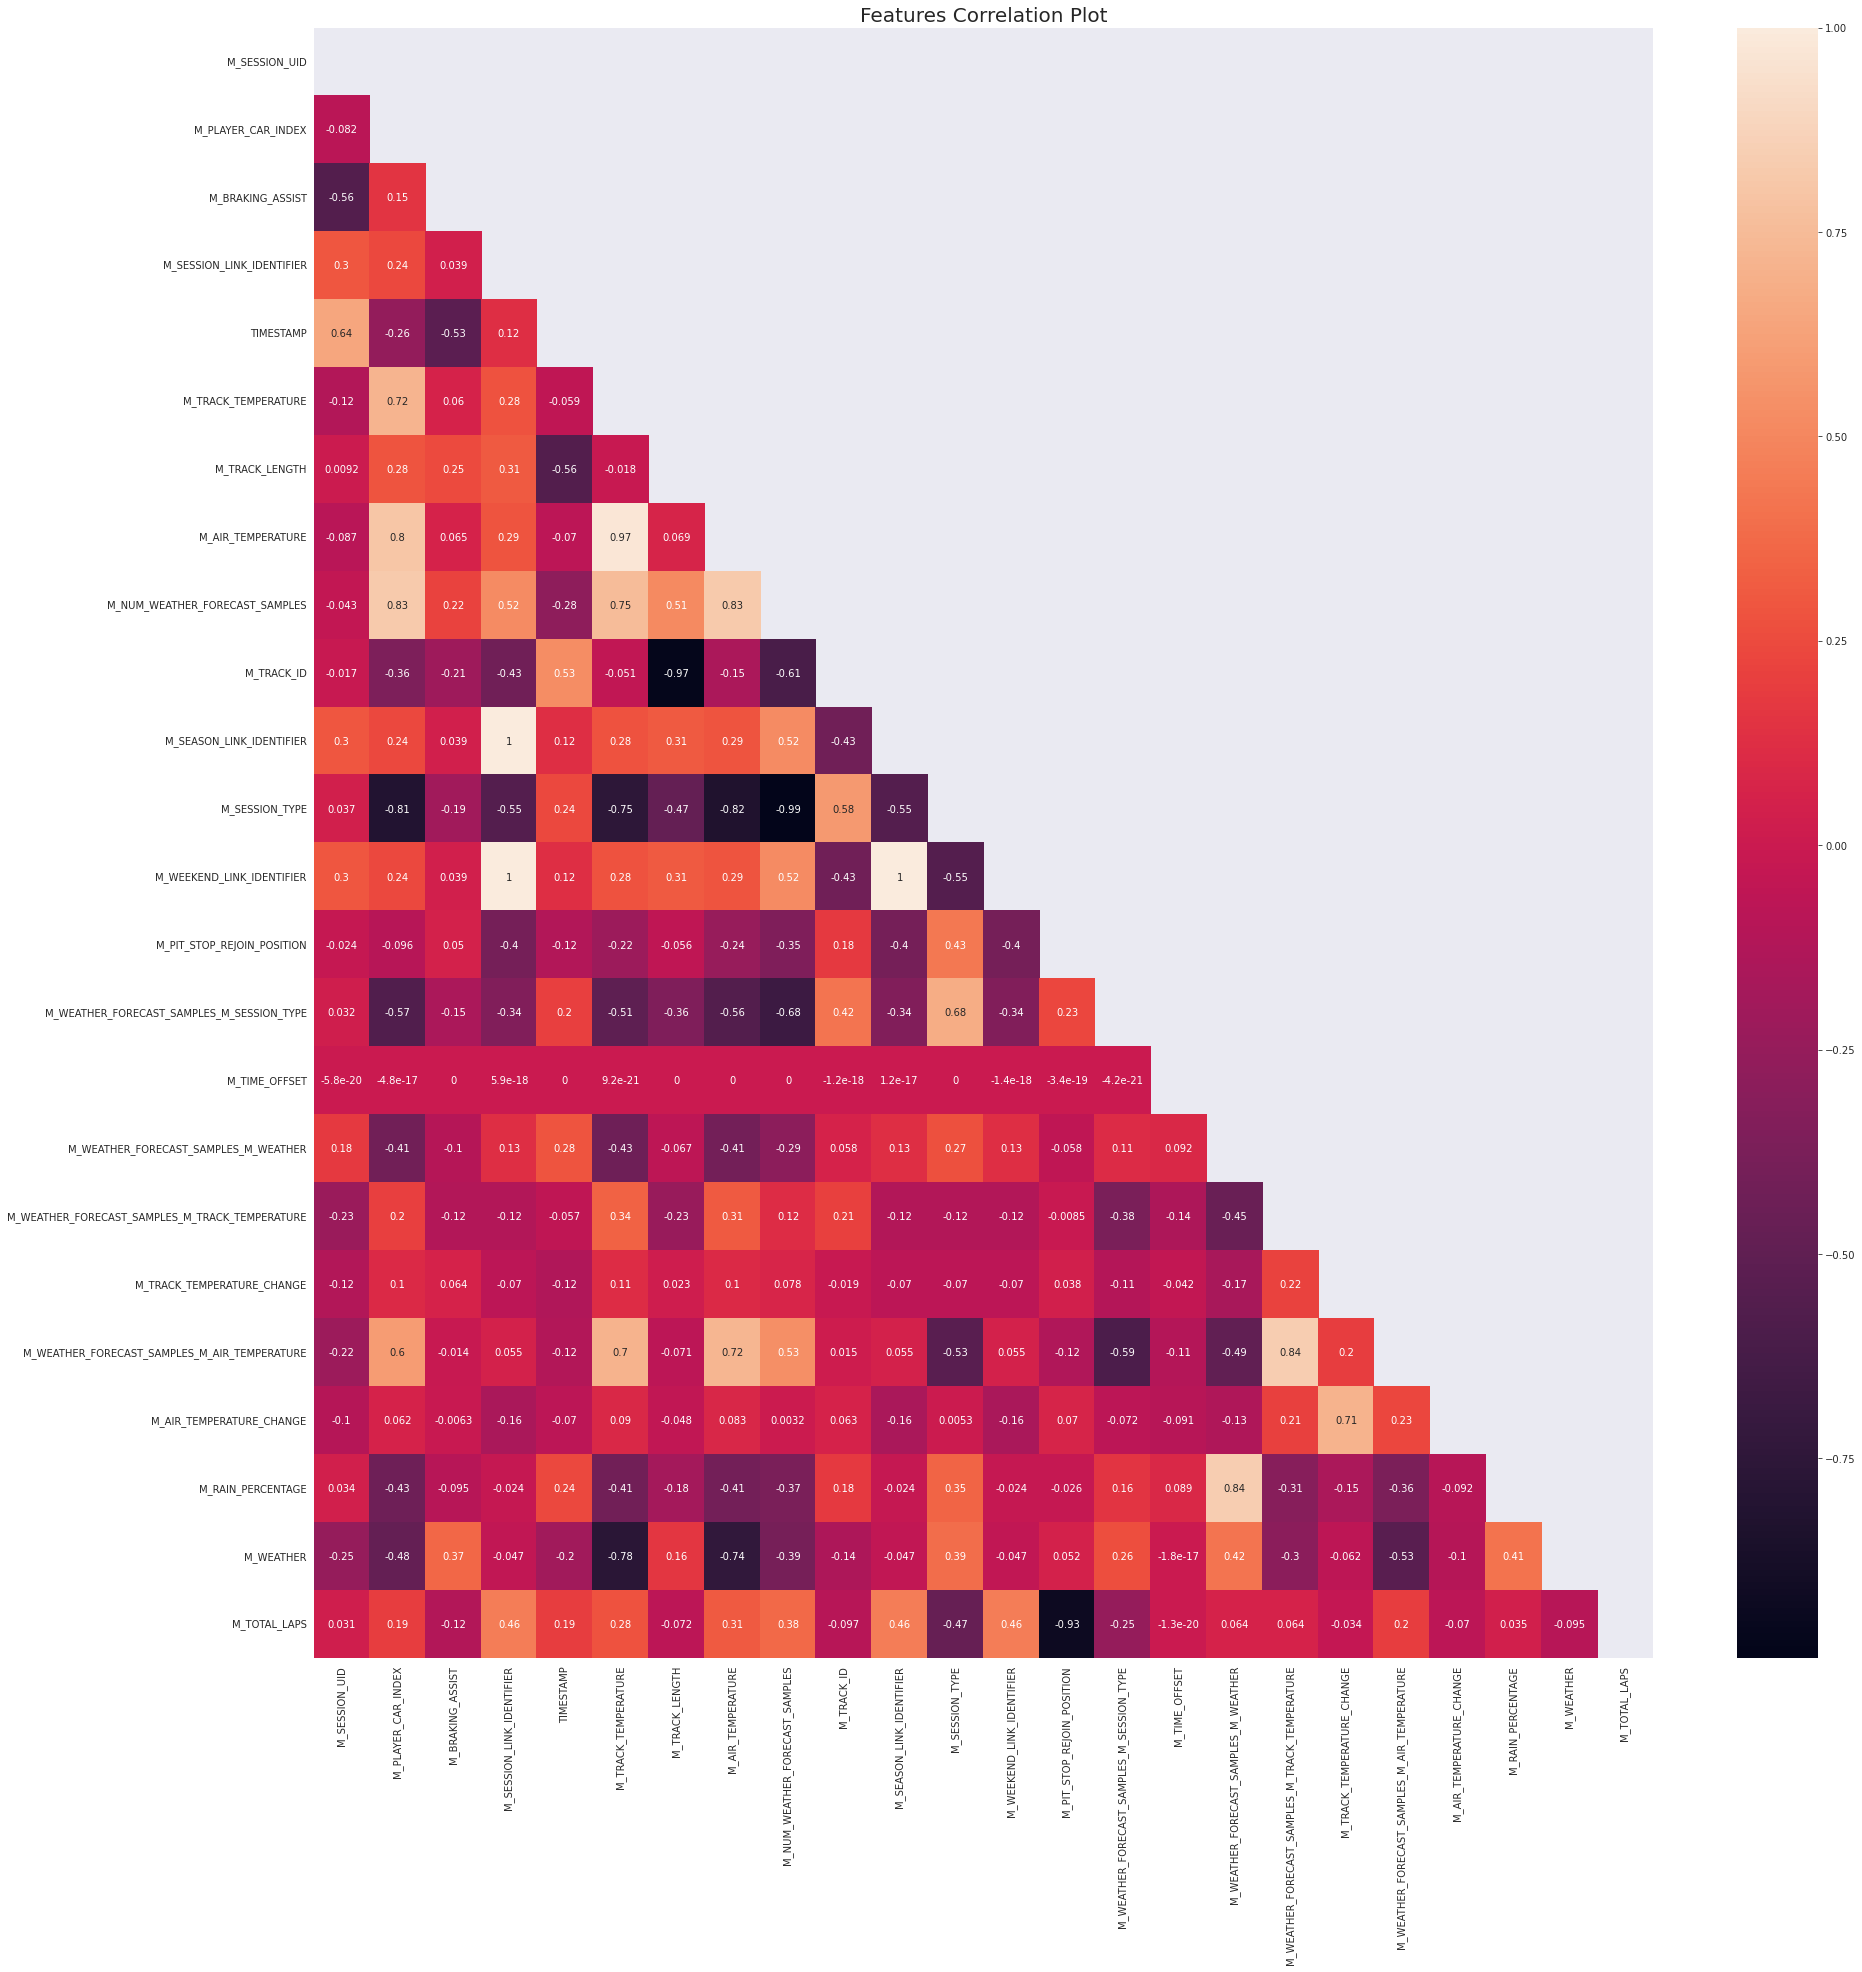

In [63]:
Heatmap_Plot(data_model.corr())

The Heat Map Plot above shows that the expected unique features TIMESTAP,PLAYER_CAR_INDEX,SESSION_UID have correlations with the target variables

Updated Corelation Plot of Features

In [64]:
# We will use the Drop_not_correlated Function defined earlier with RAIN PERCENTAGE to check for Feature that are not correlated with RAIN_PERCENTAGE
Drop_not_correlated(data_model.corr(),'M_RAIN_PERCENTAGE',0.08) # Features having correlation less than 0.02 with RAIN_PERCENTAGE

['M_SESSION_UID',
 'M_SESSION_LINK_IDENTIFIER',
 'M_SEASON_LINK_IDENTIFIER',
 'M_WEEKEND_LINK_IDENTIFIER',
 'M_PIT_STOP_REJOIN_POSITION',
 'M_TOTAL_LAPS']

In [65]:
# Drop the Features above from the updated dataset
data_model.drop(Drop_not_correlated(data_model.corr(),'M_RAIN_PERCENTAGE',0.08),axis=1,inplace=True)
data_model.head(5)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,M_PLAYER_CAR_INDEX,M_BRAKING_ASSIST,TIMESTAMP,M_TRACK_TEMPERATURE,M_TRACK_LENGTH,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_TRACK_ID,M_SESSION_TYPE,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_TIME_OFFSET,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER
17041,0,0,1.642724e+09,33,4650,25,10,28,8,10.0,0.0,1.0,32.0,1.0,24.0,1.0,5.0,0
17042,0,0,1.642724e+09,33,4650,25,10,28,8,10.0,5.0,1.0,32.0,2.0,24.0,2.0,5.0,0
17043,0,0,1.642724e+09,33,4650,25,10,28,8,10.0,10.0,1.0,32.0,2.0,24.0,2.0,5.0,0
17044,0,0,1.642724e+09,33,4650,25,10,28,8,10.0,15.0,1.0,32.0,2.0,24.0,2.0,7.0,0
17045,0,0,1.642724e+09,33,4650,25,10,28,8,10.0,30.0,1.0,31.0,1.0,24.0,2.0,17.0,0


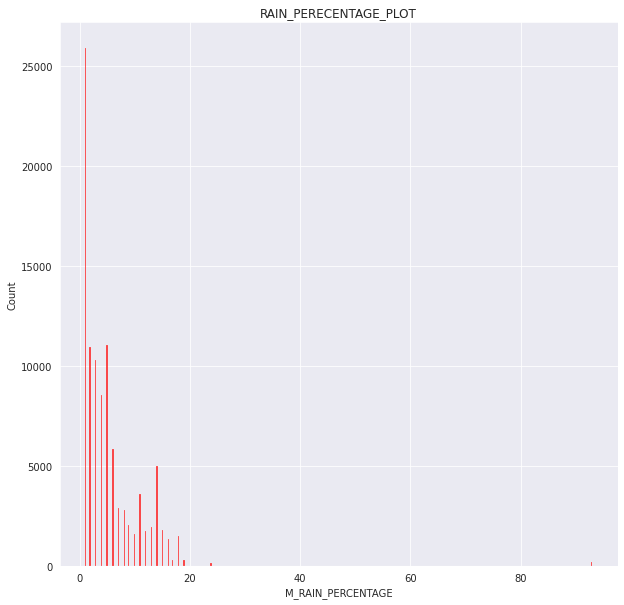

In [66]:
Hist_plot(data_model,'M_RAIN_PERCENTAGE','RAIN_PERECENTAGE_PLOT')

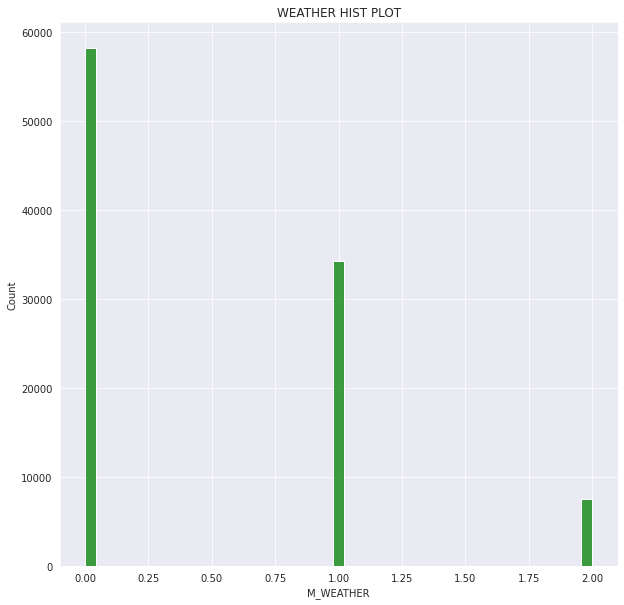

In [67]:
Hist_plot(data_model,'M_WEATHER','WEATHER HIST PLOT','g')

In [68]:
model_cols=data_model.columns
data_model.shape

(99960, 18)

In [69]:
data_model.M_WEATHER[data_model.M_WEATHER.isin([1,2])]

76636      1
76637      1
76638      1
76639      1
76640      1
          ..
2826079    2
2826080    2
2826081    2
2826082    2
2826084    2
Name: M_WEATHER, Length: 41766, dtype: int64

In [70]:
# Select Target Feature and Assign to variables
y_weather=data_model.M_WEATHER.values
y_rain=data_model.M_RAIN_PERCENTAGE.values
# Drop The Target Feature From The Dataset
data_model.drop(['M_WEATHER','M_RAIN_PERCENTAGE'],axis=1,inplace=True)
y_rain.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(99960,)

## MODEL BUILDING

The Dataset will be divided into train and validation data while the last timestamp will be reserved for use as test data. Validation data will take 1200 data points i.e 2000 Timestamps while training data will take the rest points

In [71]:
# Use Min Max scaler to rescale model to 0,1
min_max_scaler=MinMaxScaler(feature_range=(0,1))
min_max_scaler.fit(data_model[:-12000]) # Fit in Only Train data
data_model=min_max_scaler.transform(data_model)
data_model.shape

(99960, 16)

The Dataset was rescaled using Sklearn library MinMax scaler to a feature range of 0,1 .The will ensure that the features in d data will contribute significantly to the weights of the mode. This gives the features almost equal weights.

In [72]:
y_rain=y_rain/100 # Divide the Rain Percentage Data points by 100 to convert them to percentages
y_weather.shape
y_rain[:5]

array([0.05, 0.05, 0.05, 0.07, 0.17])

In [73]:
from tensorflow.keras.utils import to_categorical
# Convert The Target Weather values to Categorical Values
y_weather=to_categorical(y_weather)
y_weather.shape

(99960, 3)

In [74]:
# Patition Data Into train,Validation and test
train_data_model,y_train_rain,y_train_weather=data_model[:87960],y_rain[:87960],y_weather[:87960]
val_data_model,y_val_rain,y_val_weather=data_model[87960:-6],y_rain[87960:-6],y_weather[87960:-6]
test_point=data_model[-6:]

In [75]:
y_val_weather.shape

(11994, 3)

We will build our model using Neural Netowrks

In [76]:
# Using Keras Functional API
from tensorflow.keras import layers,Input,Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
tensorflow.random.set_seed(42)
def model_building(neurons1,neurons2,neurons3,first_dropout,second_dropout):
    # Tweets Input
    data_input=Input(shape=(16,),name='data_input')
    x=layers.Dense(neurons1,activation='relu')(data_input)
    x=layers.Dropout(first_dropout)(x)
    x=layers.Dense(neurons2,activation='relu')(x)
    x=layers.Dropout(second_dropout)(x)
    x==layers.Dense(neurons3,activation='relu')(x)
    # Multi Ouput 
    rain_output=layers.Dense(1,activation='linear',name='rain_output')(x) # Output for Rain Prediction Continous Variable
    weather_output=layers.Dense(3,activation='softmax',name='weather_output')(x) # Output for Weather Classification
    model=Model(data_input,[rain_output,weather_output])
    # Compiling The model
    callbacks=[EarlyStopping(monitor='val_loss',patience=5)]
    model.compile(optimizer='adam',loss=['mae','categorical_crossentropy'],metrics=['mae','acc'])
    return model
model=model_building(64,32,16,0,0)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data_input (InputLayer)         [(None, 16)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           1088        data_input[0][0]                 
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64)           0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dropout[0][0]                    
______________________________________________________________________________________________

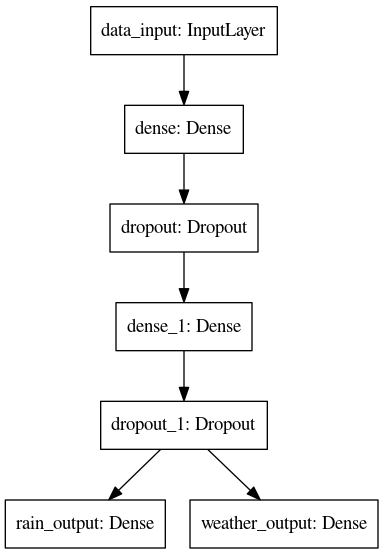

In [77]:
plot_model(model)

The plot above shows the Network Graph of the model from input to output. a single input Mulit-Output Network Graph was implemented using Keras functional API. It has an Input layer that takes the data, this layer passes it through 3 hidden dense layers with decreasing neurons, this is then passed to two output layers.
The First output layer is the Rain_percentage prediction layer with a linear activation. while the second Ouput layer is the Weather Prediction Layer with a 'softmax' layer to predict the multiple classes in the weather class. The Hyperparameters are arbtarily selected at thhis instance. No value for the dropout layer is used (dropout=0).

EarlyStopping callback is used to monitor the validation loss and stops training when value stops decreasing after 20 epochs

In [78]:
callbacks=[EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)]
history=model.fit(train_data_model,[y_train_rain,y_train_weather],epochs=30,batch_size=72,shuffle=False,callbacks=callbacks,validation_data=(val_data_model,[y_val_rain,y_val_weather]))

Epoch 1/30
1222/1222 [==============================] - 4s 3ms/step - loss: 0.4409 - rain_output_loss: 0.0300 - weather_output_loss: 0.4109 - rain_output_mae: 0.0300 - rain_output_acc: 0.0000e+00 - weather_output_mae: 0.1561 - weather_output_acc: 0.8218 - val_loss: 2.5475 - val_rain_output_loss: 0.0800 - val_weather_output_loss: 2.4675 - val_rain_output_mae: 0.0800 - val_rain_output_acc: 0.0000e+00 - val_weather_output_mae: 0.3630 - val_weather_output_acc: 0.4447
Epoch 2/30
1222/1222 [==============================] - 3s 2ms/step - loss: 0.3903 - rain_output_loss: 0.0296 - weather_output_loss: 0.3607 - rain_output_mae: 0.0296 - rain_output_acc: 0.0000e+00 - weather_output_mae: 0.1298 - weather_output_acc: 0.8487 - val_loss: 1.8780 - val_rain_output_loss: 0.0259 - val_weather_output_loss: 1.8521 - val_rain_output_mae: 0.0259 - val_rain_output_acc: 0.0000e+00 - val_weather_output_mae: 0.3498 - val_weather_output_acc: 0.4447
Epoch 3/30
1222/1222 [==============================] - 3s 2ms/s

The Loss Function to be optimized is the sum of the loss of the 2 output layers. rain_percentage output layer yields loss in the range 0-1 same with weather prediction. This contributes almost equally to the combined loss therefore the loss weights are 1 and 1 

In [80]:
history.history.keys()

dict_keys(['loss', 'rain_output_loss', 'weather_output_loss', 'rain_output_mae', 'rain_output_acc', 'weather_output_mae', 'weather_output_acc', 'val_loss', 'val_rain_output_loss', 'val_weather_output_loss', 'val_rain_output_mae', 'val_rain_output_acc', 'val_weather_output_mae', 'val_weather_output_acc'])

In [81]:
# A Function to Plot Model Output 
def Plot_Parameter(parameter):
    plt.figure(figsize=(10,10))
    sns.set_style('darkgrid')
    plt.title(parameter.capitalize()+'_Epochs Plot')
    sns.lineplot(x=[i for i in range(len(history.history[parameter]))],y=history.history[parameter],color='r',label='Train_'+parameter.capitalize())
    sns.lineplot(x=[i for i in range(len(history.history[parameter]))],y=history.history['val_'+parameter],color='g',label='Validation_'+parameter.capitalize())
    if parameter in ['acc']:
        plt.ylim([0,1])
    plt.legend(loc='best');plt.grid(True)
    

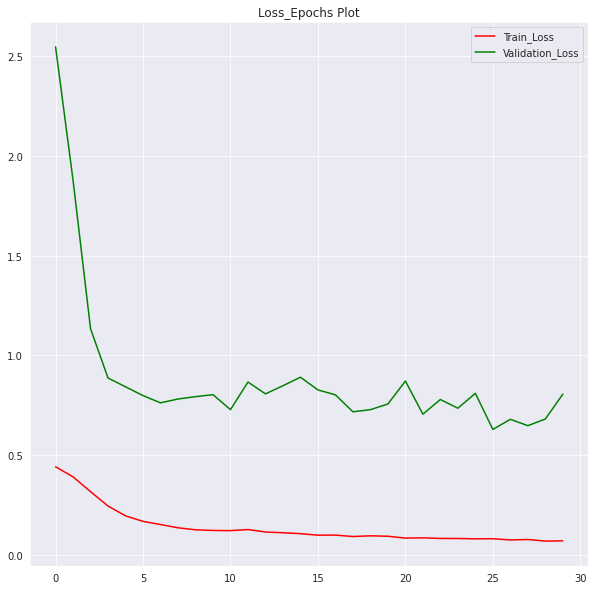

In [82]:
# Plotting Loss
Plot_Parameter('loss')

In [83]:
# Evaluate Model on validation data
model.evaluate(val_data_model,[y_val_rain,y_val_weather])

375/375 [==============================] - 1s 2ms/step - loss: 0.8052 - rain_output_loss: 0.0176 - weather_output_loss: 0.7876 - rain_output_mae: 0.0176 - rain_output_acc: 0.0000e+00 - weather_output_mae: 0.1140 - weather_output_acc: 0.9125


[0.8052011728286743,
 0.017637256532907486,
 0.7875645756721497,
 0.017637256532907486,
 0.0,
 0.1139596626162529,
 0.912456214427948]

In [84]:
# Function To Evaluate and Analyze our model Ouput
def Output_estimate(model_prediction):
    rain_pred=model_prediction[0]
    weather_pred=model_prediction[1]
    weather_pred=[x.argmax() for x in weather_pred]
    y_val_model=[x.argmax() for x in y_val_weather]
    # Print Accuracy score of Weather Predictions
    print('Weather Prediction Accuracy Score: {}'.format(accuracy_score(weather_pred,y_val_model)))
    print()
    # Plot Confusion Matrix of Weather Prediction
    plt.figure(figsize=(10,10))
    plt.title('WEATHER PREDICTION CONFUSION MATRIX PLOT')
    sns.heatmap(confusion_matrix(weather_pred,y_val_model),annot=True,label=[0,1,2])
    # Print Mean Absolute Error Score of Weather
    print('Mean Absolute Error (mae) of Rain Prediction is: {:.2f}'.format(mean_absolute_error(rain_pred,y_val_rain)))

Weather Prediction Accuracy Score: 0.912456228114057

Mean Absolute Error (mae) of Rain Prediction is: 0.02


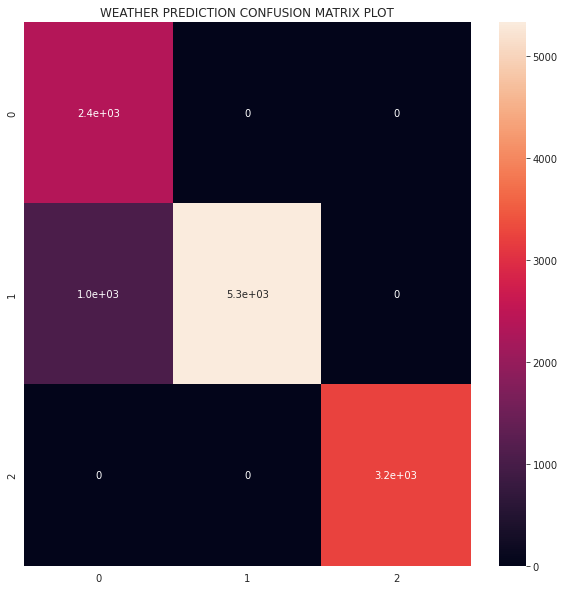

In [85]:
Output_estimate(model.predict(val_data_model))

### HYPERPARAMETER TUNING USING BAYESIAN OPTIMIZATION

In [86]:
from bayes_opt import BayesianOptimization

In [87]:
# Creating A Fuction for Optimization
def model_optimize(neurons1,neurons2,neurons3,first_dropout,second_dropout,optimizer_rate):
    neurons1=round(neurons1);neurons2=round(round(neurons2)); neurons3=round(neurons3)
    first_dropout=first_dropout;second_dropout=second_dropout
    optimizer_rate=optimizer_rate
    model=model_building(neurons1=neurons1,neurons2=neurons2,neurons3=neurons3,first_dropout=first_dropout,second_dropout=second_dropout)
    callbacks=tensorflow.keras.callbacks.EarlyStopping(monitor='loss',patience=5,verbose=0)
    history=model.fit(train_data_model,[y_train_rain,y_train_weather],epochs=50,batch_size=144,shuffle=False,callbacks=callbacks)
    score=model.evaluate(val_data_model,[y_val_rain,y_val_weather])[0]
    return -score

In [88]:
# Set Parameters
params_nn=dict(neurons1=(10,128),neurons2=(10,100),neurons3=(10,100),first_dropout=(0.2,0.8),second_dropout=(0.2,0.8),optimizer_rate=(0.0001,0.1))
params_nn

{'neurons1': (10, 128),
 'neurons2': (10, 100),
 'neurons3': (10, 100),
 'first_dropout': (0.2, 0.8),
 'second_dropout': (0.2, 0.8),
 'optimizer_rate': (0.0001, 0.1)}

In [89]:
# Fitting Bayesian Optimization
nn_bo=BayesianOptimization(f=model_optimize,pbounds=params_nn,random_state=42,verbose=1)
nn_bo.maximize(init_points=5,n_iter=1)
for i,res in enumerate(nn_bo.res):
    print('Iteration {}: \n\t{}'.format(i,res))
print(nn_bo.max)

|   iter    |  target   | first_... | neurons1  | neurons2  | neurons3  | optimi... | second... |
-------------------------------------------------------------------------------------------------
Epoch 1/50
611/611 [==============================] - 3s 3ms/step - loss: 0.5962 - rain_output_loss: 0.0686 - weather_output_loss: 0.5276 - rain_output_mae: 0.0686 - rain_output_acc: 0.0000e+00 - weather_output_mae: 0.1740 - weather_output_acc: 0.8121
Epoch 2/50
611/611 [==============================] - 2s 3ms/step - loss: 0.5330 - rain_output_loss: 0.0365 - weather_output_loss: 0.4965 - rain_output_mae: 0.0365 - rain_output_acc: 0.0000e+00 - weather_output_mae: 0.1720 - weather_output_acc: 0.7979
Epoch 3/50
611/611 [==============================] - 2s 3ms/step - loss: 0.4671 - rain_output_loss: 0.0356 - weather_output_loss: 0.4315 - rain_output_mae: 0.0356 - rain_output_acc: 0.0000e+00 - weather_output_mae: 0.1611 - weather_output_acc: 0.8103
Epoch 4/50
611/611 [============================

In [90]:
print("Best result: {}; f(x) = {}.".format(nn_bo.max["params"], nn_bo.max["target"]))
best_params=nn_bo.max['params']

Best result: {'first_dropout': 0.4736419905302216, 'neurons1': 102.6507634443756, 'neurons2': 27.970640394252378, 'neurons3': 56.28109945722505, 'optimizer_rate': 0.059282215429318046, 'second_dropout': 0.22787024763199865}; f(x) = -1.343741536140442.


In [92]:
# Training With Best Found Parameters
model_opt=model_building(103,28,56,0.5,0.2)
callbacks=[EarlyStopping(monitor='val_loss',patience=50)]
history=model_opt.fit(train_data_model,[y_train_rain,y_train_weather],epochs=50,batch_size=136,shuffle=False,callbacks=callbacks,validation_data=(val_data_model,[y_val_rain,y_val_weather]))

Epoch 1/50
647/647 [==============================] - 3s 3ms/step - loss: 0.5975 - rain_output_loss: 0.0823 - weather_output_loss: 0.5153 - rain_output_mae: 0.0823 - rain_output_acc: 0.0000e+00 - weather_output_mae: 0.1855 - weather_output_acc: 0.8126 - val_loss: 3.6080 - val_rain_output_loss: 0.0371 - val_weather_output_loss: 3.5709 - val_rain_output_mae: 0.0371 - val_rain_output_acc: 0.0000e+00 - val_weather_output_mae: 0.3685 - val_weather_output_acc: 0.4447
Epoch 2/50
647/647 [==============================] - 2s 3ms/step - loss: 0.5810 - rain_output_loss: 0.0367 - weather_output_loss: 0.5444 - rain_output_mae: 0.0367 - rain_output_acc: 0.0000e+00 - weather_output_mae: 0.1869 - weather_output_acc: 0.7981 - val_loss: 2.3464 - val_rain_output_loss: 0.0438 - val_weather_output_loss: 2.3027 - val_rain_output_mae: 0.0438 - val_rain_output_acc: 0.0000e+00 - val_weather_output_mae: 0.3562 - val_weather_output_acc: 0.4447
Epoch 3/50
647/647 [==============================] - 2s 3ms/step - 

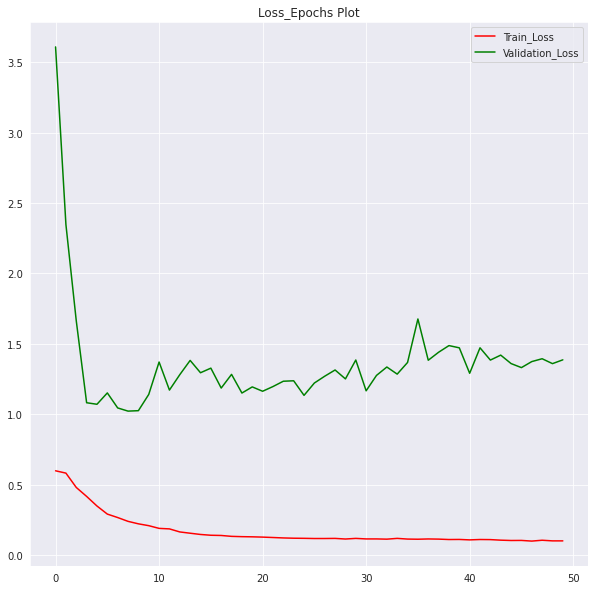

In [93]:
# Plotting Loss
Plot_Parameter('loss')

The Model Optimization Plot above shows that the Hyperameter Tuned Model performs worse than our base model

In [94]:
# Evaluate Optimized Model on validation data
model_opt.evaluate(val_data_model,[y_val_rain,y_val_weather])

375/375 [==============================] - 1s 2ms/step - loss: 1.3856 - rain_output_loss: 0.0378 - weather_output_loss: 1.3478 - rain_output_mae: 0.0378 - rain_output_acc: 0.0000e+00 - weather_output_mae: 0.1296 - weather_output_acc: 0.7267


[1.3856117725372314,
 0.037792813032865524,
 1.3478202819824219,
 0.037792813032865524,
 0.0,
 0.1296154111623764,
 0.7266966700553894]

Weather Prediction Accuracy Score: 0.7266966816741705

Mean Absolute Error (mae) of Rain Prediction is: 0.04


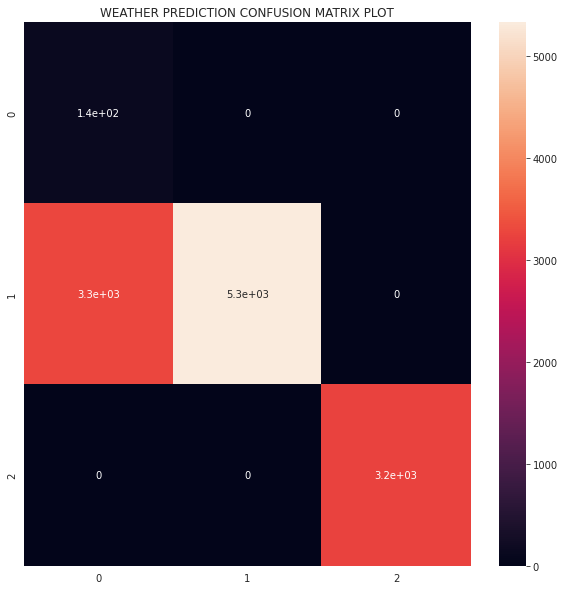

In [95]:
# Scores of Tuned Model
Output_estimate(model_opt.predict(val_data_model))

Our First Non-Tuned Model performed better than that optimized using Bayesian Optimization. Therefore we select our First Model

### SELECTED MODEL TEST

In [96]:
# Evaluate Model on validation data
model.evaluate(val_data_model,[y_val_rain,y_val_weather])

375/375 [==============================] - 1s 2ms/step - loss: 0.8052 - rain_output_loss: 0.0176 - weather_output_loss: 0.7876 - rain_output_mae: 0.0176 - rain_output_acc: 0.0000e+00 - weather_output_mae: 0.1140 - weather_output_acc: 0.9125


[0.8052011728286743,
 0.017637256532907486,
 0.7875645756721497,
 0.017637256532907486,
 0.0,
 0.1139596626162529,
 0.912456214427948]

Weather Prediction Accuracy Score: 0.912456228114057

Mean Absolute Error (mae) of Rain Prediction is: 0.02


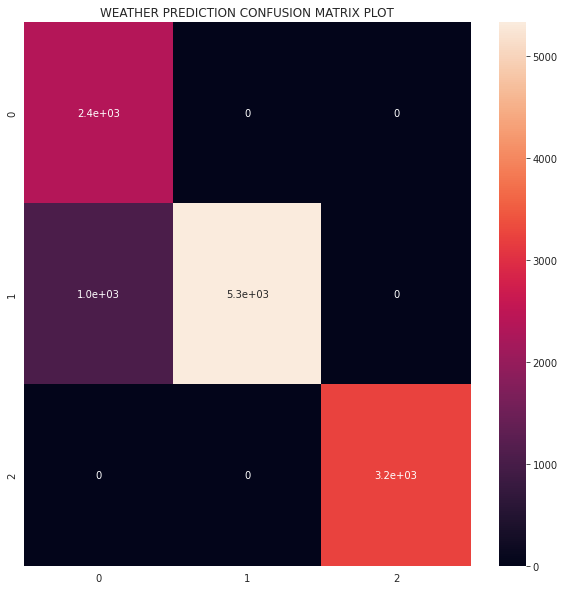

In [97]:
# Scores of Selected Model
Output_estimate(model.predict(val_data_model))

In [98]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


### MODEL TESTING AND OUTPUT


In [101]:
model=tensorflow.keras.models.load_model('my_model') # Load Model
# Test Model on a TimeStamp
model.predict(test_point)

[array([[0.05063879],
        [0.04385569],
        [0.04432145],
        [0.04478722],
        [0.04629708],
        [0.05673999]], dtype=float32),
 array([[5.9903544e-01, 4.0090820e-01, 5.6392735e-05],
        [5.7024837e-01, 4.2968291e-01, 6.8704700e-05],
        [5.7499832e-01, 4.2493838e-01, 6.3361564e-05],
        [5.7973421e-01, 4.2020738e-01, 5.8428664e-05],
        [5.9392649e-01, 4.0602779e-01, 4.5646269e-05],
        [7.5996846e-01, 2.4001780e-01, 1.3772717e-05]], dtype=float32)]

In [102]:
# Function to construct Dict From Test Point
def Dict_formation(model_prediction):
    rain_pred,weather_pred=model_prediction
    weather_pred=[x.argmax() for x in weather_pred]
    output_dict=dict()
    for time_offset,rain_pred_point,weather_pred_point in zip(['5','10','15','30','60'],rain_pred[1:],weather_pred[1:]):
        output_dict[time_offset]={'type':weather_pred_point,'rain_percentage':rain_pred_point[0]}
    return output_dict
        

In [103]:
Dict_formation(model.predict(test_point)) 

{'5': {'type': 0, 'rain_percentage': 0.04385569},
 '10': {'type': 0, 'rain_percentage': 0.04432145},
 '15': {'type': 0, 'rain_percentage': 0.04478722},
 '30': {'type': 0, 'rain_percentage': 0.04629708},
 '60': {'type': 0, 'rain_percentage': 0.056739986}}